# IMPORT & DRIVE

In [ ]:
#import utili
import numpy as np
import pandas as pd 
import seaborn as sns
from google.colab import drive
import os

#grafici & co
import matplotlib.pyplot as plt


#date-time 
from datetime import datetime
from datetime import date

#analisi 
from sklearn import linear_model
from sklearn import utils
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats

#knn - svm - tree 
from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn import svm, metrics
from random import randrange
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_text

from datetime import datetime
start = datetime.now()                         


In [ ]:
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoBDA/'


Mounted at /content/drive


In [ ]:
os.chdir(path)
os.listdir()

['iscritti_p62.csv',
 'query_62.txt',
 'libretto_62.csv',
 'decision_tree.png',
 'appelli.csv',
 'a.csv',
 'result_unico.csv',
 'modello predittivo.csv']

# LOAD DATA FRAME

In [ ]:

print("--------------ISCRITTI-----------------")
DF_iscritti = pd.read_csv('iscritti_p62.csv', header=0,sep=',') 
print("PRE PULIZIA RIGHE : {}".format(DF_iscritti.shape[0]))

print("PULIZIA OUTLIERS/VALORI NON CORRETTI ISCRITTI")
DF_iscritti.drop(DF_iscritti[DF_iscritti.BASE_VOTO < 60].index, inplace = True)
DF_iscritti.drop(DF_iscritti[DF_iscritti.BASE_VOTO.isnull()].index, inplace = True)
DF_iscritti.drop(DF_iscritti[DF_iscritti.VOTO.isnull()].index, inplace = True)
DF_iscritti.drop(DF_iscritti[DF_iscritti['MIUR_SCUOLE_COD'].isnull()].index, inplace= True)

for index, row in DF_iscritti.iterrows(): 
  row['VOTO'] = (row['VOTO'] * 100) / row['BASE_VOTO']

DF_iscritti.sort_values('MATRICOLA', inplace = True)
Duplicati_Iscritti = DF_iscritti[DF_iscritti.duplicated(subset=["MATRICOLA","PERS_ID"])]
if not Duplicati_Iscritti.empty:
  DF_iscritti.drop_duplicates(subset =["MATRICOLA","PERS_ID"], keep = False, inplace = True)  
else:
  print('Non sono presenti duplicati in iscritti')

print("POST PULIZIA RIGHE : {}".format(DF_iscritti.shape[0]))

print("--------------LIBRETTO-----------------")
DF_libretto = pd.read_csv('libretto_62.csv', header=0, sep=',') 
print("PRE PULIZIA RIGHE : {}".format(DF_libretto.shape[0]))

print("PULIZIA OUTLIERS/VALORI NON CORRETTI LIBRETTO")
for index, row in DF_libretto.iterrows():
  voto = row["AVG(VOTO)"]

  if voto != 0:
      voto_nuovo =  round(voto / 1000000,2)
      row['AVG(VOTO)'] = voto_nuovo; 
DF_libretto.drop(DF_libretto[DF_libretto["AVG(VOTO)"] < 18].index, inplace = True)
DF_libretto.drop(DF_libretto[DF_libretto["min(DATA_SUP)"].isnull()].index, inplace = True)
DF_libretto.drop(DF_libretto.loc[DF_libretto["min(DATA_SUP)"] < "1980-01-01"].index, inplace = True) 
DF_libretto.sort_values('MATRICOLA', inplace = True)
Duplicati_libretto = DF_libretto[DF_libretto.duplicated(subset =["MATRICOLA"])]
if not Duplicati_libretto.empty:
  DF_libretto.drop_duplicates(subset =["MATRICOLA"], keep = False, inplace = True)
else:
  print('Non sono presenti duplicati libretto')
print("POST PULIZIA RIGHE : {}".format(DF_libretto.shape[0]))



--------------ISCRITTI-----------------
PRE PULIZIA RIGHE : 19899
PULIZIA OUTLIERS/VALORI NON CORRETTI ISCRITTI
POST PULIZIA RIGHE : 16453
--------------LIBRETTO-----------------
PRE PULIZIA RIGHE : 25652
PULIZIA OUTLIERS/VALORI NON CORRETTI LIBRETTO
POST PULIZIA RIGHE : 23390


# MERGE DATA FRAME

In [ ]:
#DF_UNICO = DF_iscritti.join(DF_libretto, how='inner', lsuffix='L_', rsuffix='R_', sort=False)
DF_UNICO = pd.merge(DF_iscritti,DF_libretto, on="MATRICOLA")
print(DF_UNICO.columns.values)

print("DF UNICO ROWS : {}".format(DF_UNICO.shape[0]))

DF_UNICO.head()



['PERS_ID' 'MATRICOLA' 'AA_ISCR_ID' 'CDS_ID_x' 'SESSO' 'AA_CONSEG_TITOLO'
 'VOTO' 'LODE' 'BASE_VOTO' 'MIUR_SCUOLE_COD' 'Tipo_EDUSCOPIO' 'CDS_ID_y'
 'AVG(VOTO)' 'sum(PESO_AD)' 'AA_SUP_ID' 'min(DATA_SUP)']
DF UNICO ROWS : 12882


,PERS_ID,MATRICOLA,AA_ISCR_ID,CDS_ID_x,SESSO,AA_CONSEG_TITOLO,VOTO,LODE,BASE_VOTO,MIUR_SCUOLE_COD,Tipo_EDUSCOPIO,CDS_ID_y,AVG(VOTO),sum(PESO_AD),AA_SUP_ID,min(DATA_SUP)
0,29AE4E616F531F66A98F9323FE63DB77,00027EDDD55C51F668558C1BBC93852D,2020,10362,M,2020,74.0,0,100.0,PSPS01000G,Scientifico,10362,20.000000,12.0,2020,2021-04-12 00:00:00
1,2FD123EE6A3914B846CF2CC091016E84,0004D7F73A2E5D764603CD68DCDEC115,2019,10362,F,2016,61.0,0,100.0,PSPS020006,Scientifico Scienze applicate,10362,27.000000,16.0,2019,2020-01-30 00:00:00
2,C4E48C39CCF876F937A41C48923FCD7F,0010B15A6FE7B318A144E2B5C8A87CC5,2017,10204,M,2017,67.0,0,100.0,CHPS00301T,Scientifico,10204,22.000000,27.0,2017,2018-01-23 00:00:00
3,DB6CB9B6DBA3C630AFE95AADEC2B4C11,00122E576F0F42D3C800EB8F9BB6D35F,2016,10040,M,2016,62.0,0,100.0,APPS030005,Scientifico,10040,22.714286,60.0,2016,2017-02-13 00:00:00
4,0756DC8F726266FB88782DF74A80B516,00152A8901E4C527DF527DBFFAF73B42,2015,10179,F,2014,63.0,0,100.0,PDIS01300X,Classico,10179,27.384615,54.0,2015,2016-02-08 00:00:00


# ANALISI TIPOLOGIE SCUOLE E ISCRITTI

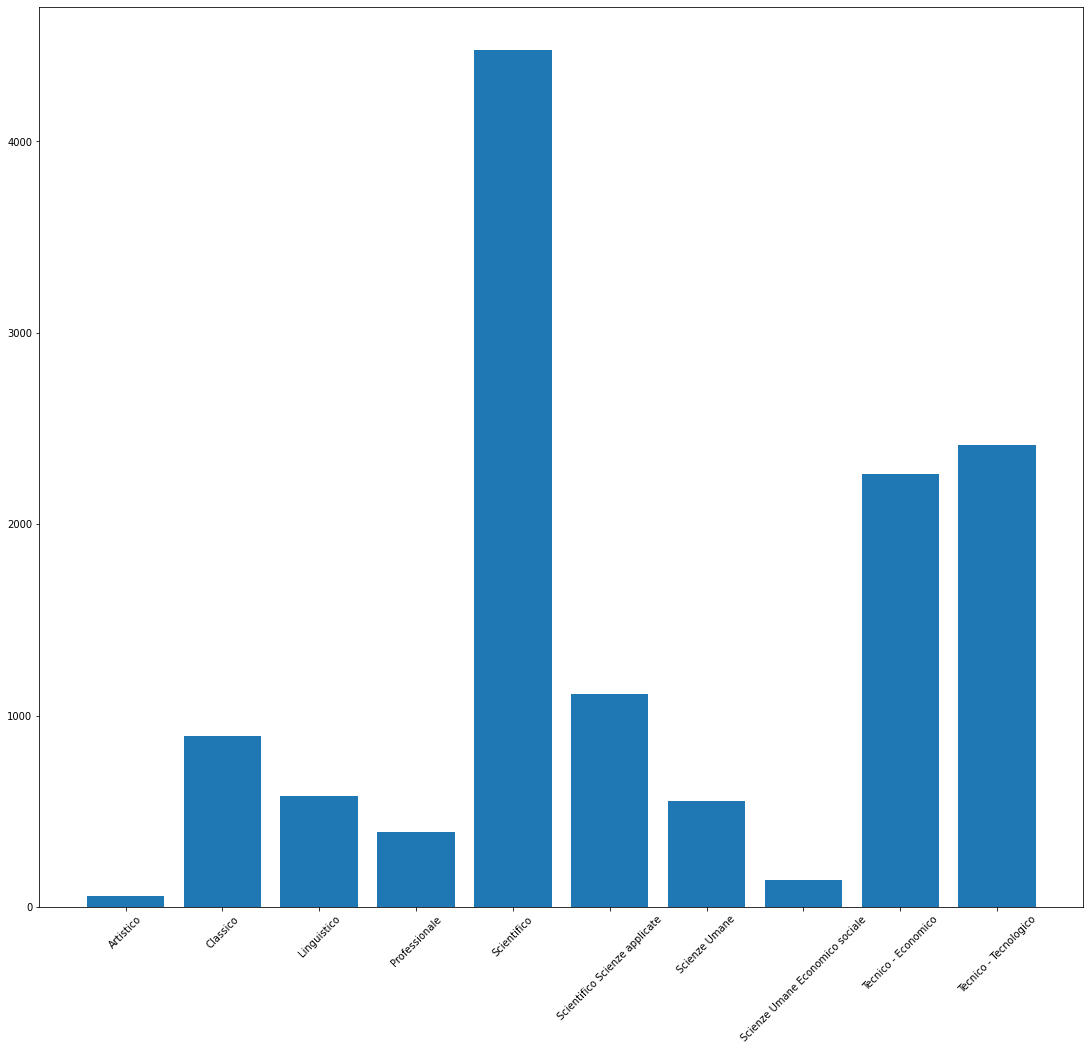

In [ ]:
Scuole_Superiori = DF_UNICO.groupby(DF_UNICO.Tipo_EDUSCOPIO)
Tipologie_di_scuole = Scuole_Superiori.groups.keys(); 

sum = 0
i = 0
n_iscritti_per_tipo_scuola = np.empty(len(Tipologie_di_scuole), dtype=object)
for x in Tipologie_di_scuole:
  scuola = Scuole_Superiori.get_group(x)
  n_iscritti = scuola.shape[0]
  n_iscritti_per_tipo_scuola[i] = n_iscritti
  i+=1
  sum = sum + scuola.shape[0]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1]) 
x_campo = list(Tipologie_di_scuole)
y_campo = n_iscritti_per_tipo_scuola
fig.set_size_inches(14.5, 12.5)
ax.bar(x_campo,y_campo)
plt.xticks(rotation=45)
plt.show()

# ANALISI PROVENIENZA SCUOLA E ISCRIZIONI UNIVERSITÀ - Regole di Associazione 

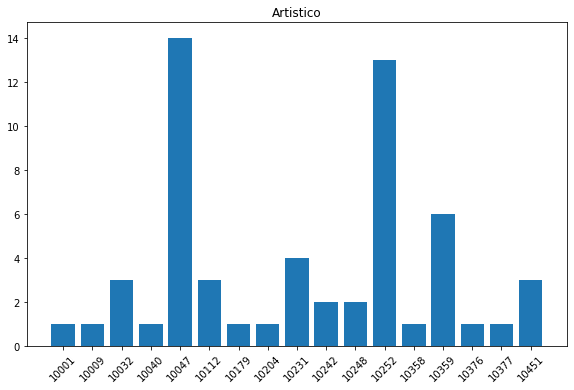

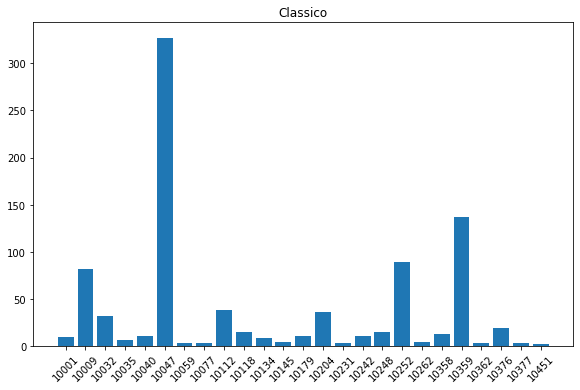

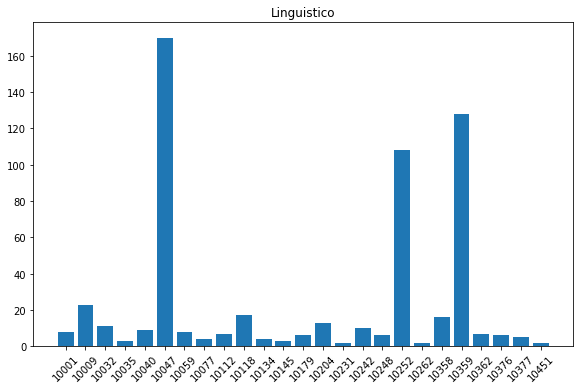

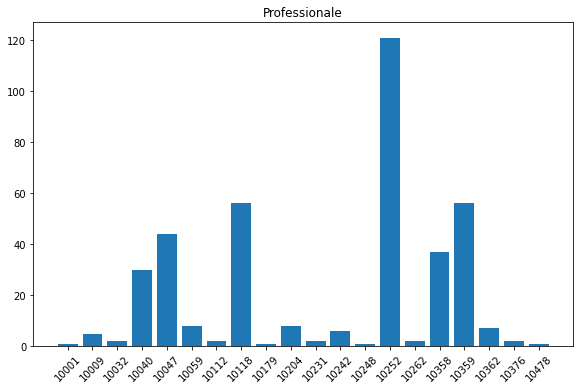

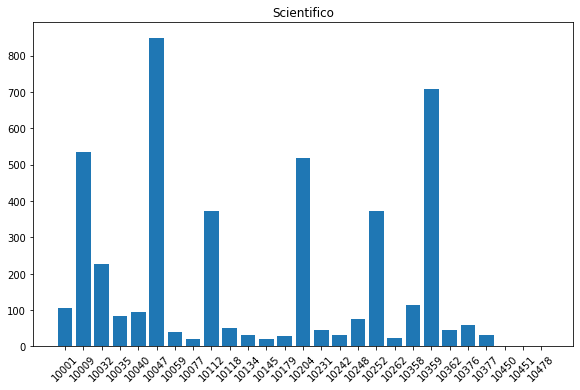

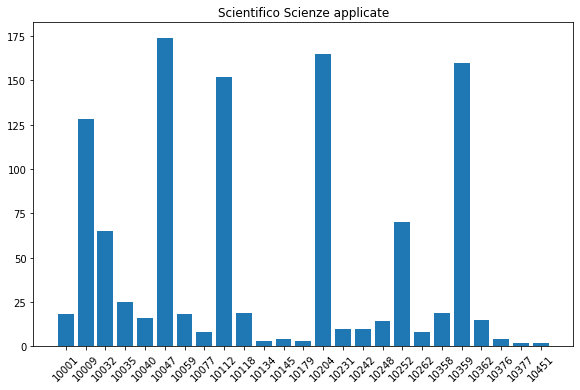

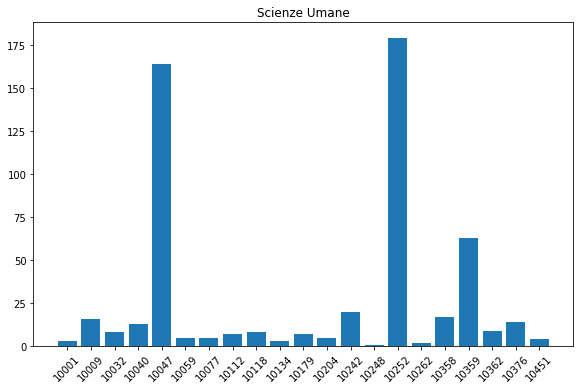

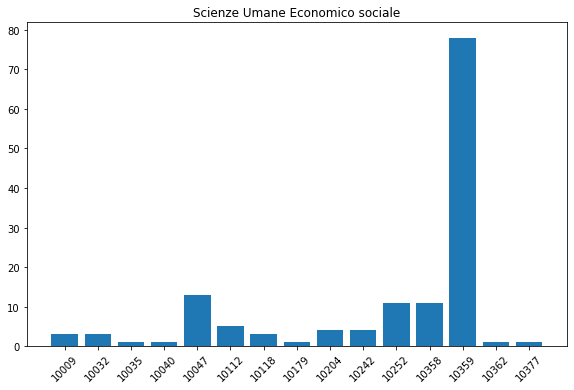

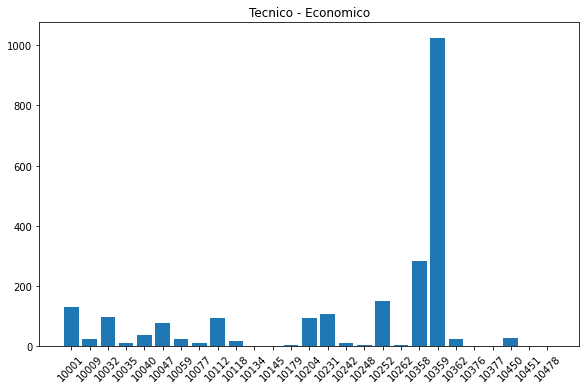

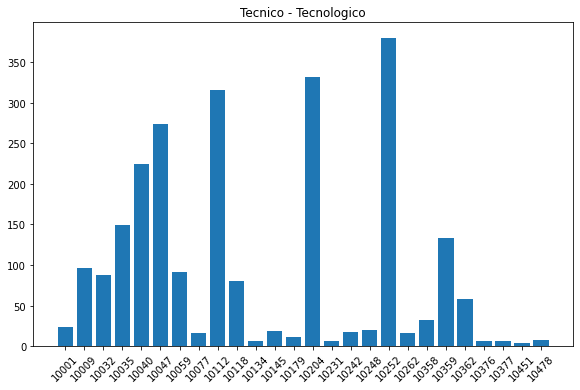

Text(0.5, 114.0, 'Facoltà')

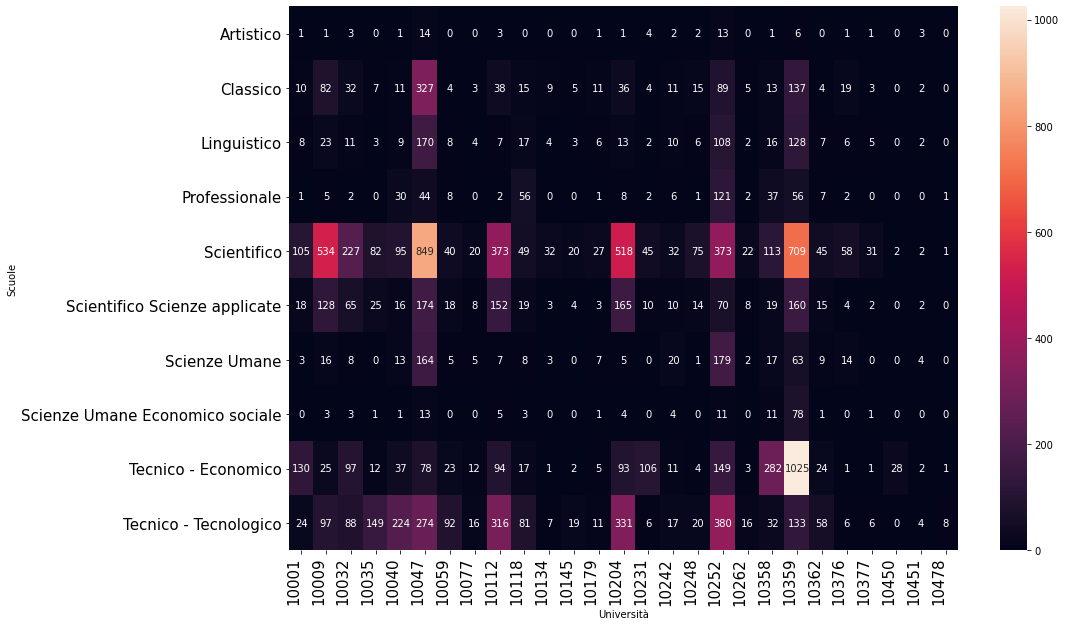

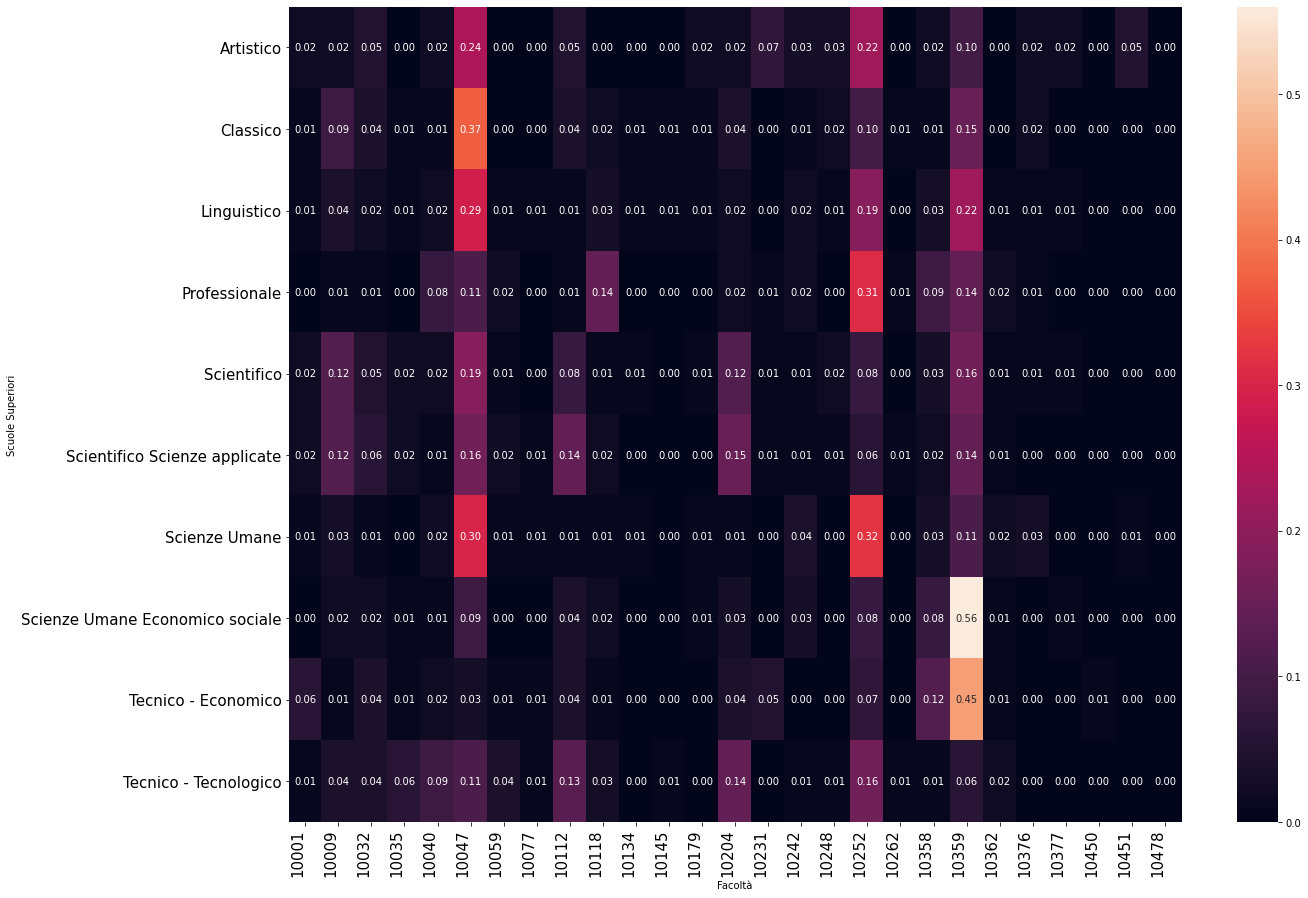

In [ ]:
Scuole_Superiori = DF_UNICO.groupby(DF_UNICO.Tipo_EDUSCOPIO)
Tipologie_di_scuole = Scuole_Superiori.groups.keys(); 

Facolta_Universita = DF_UNICO.groupby(DF_UNICO.CDS_ID_y)
Tipologie_di_Facolta = Facolta_Universita.groups.keys(); 
matrice_confusione_iscritti = pd.DataFrame(0,index=Tipologie_di_scuole, columns=Tipologie_di_Facolta)
matrice_confusione_confidenza = pd.DataFrame(0.000,index=Tipologie_di_scuole, columns=Tipologie_di_Facolta)

k = 0
scuole = []
universita_t = []
for x in Tipologie_di_scuole:
  n_iscritti_totale = 0
  tipo_scuola = x
  scuola = Scuole_Superiori.get_group(x)
  iscritti_CDS = scuola.groupby(scuola.CDS_ID_x)
  universita = iscritti_CDS.groups.keys()
  n_iscritti_per_universita = np.empty(len(list(universita)), dtype=object)
  k = 0
  for y in universita:
    scuola_CDS = iscritti_CDS.get_group(y)
    n_iscritti = scuola_CDS.shape[0]
    n_iscritti_per_universita[k] = n_iscritti
    matrice_confusione_iscritti.at[x,y] = n_iscritti
    matrice_confusione_confidenza.at[x,y] = n_iscritti
    k+=1
    n_iscritti_totale += n_iscritti
  for y in universita:
    matrice_confusione_confidenza.at[x,y] = round(matrice_confusione_confidenza.at[x,y]/n_iscritti_totale,2)
  universita_ = np.empty(len(list(universita)), dtype=object)
  j = 0
  for x in list(universita): 
    universita_[j] = str(x)
    j+=1
  
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1]) 
  x_campo = list(universita_)
  y_campo = n_iscritti_per_universita
  fig.set_size_inches(7.5, 4.5)
  ax.bar(x_campo,y_campo)
  plt.xticks(rotation=45)
  plt.title(tipo_scuola)
  plt.show()

plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(matrice_confusione_iscritti, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right',fontsize=15)
plt.ylabel('Scuole')
plt.xlabel('Università')

plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(matrice_confusione_confidenza, annot=True, fmt=".2f")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right',fontsize=15)
plt.ylabel('Scuole Superiori')
plt.xlabel('Facoltà')

# ANALISI UNIVERSITÀ e SCUOLA DI PROVENIENZA - Regole di Associazione 


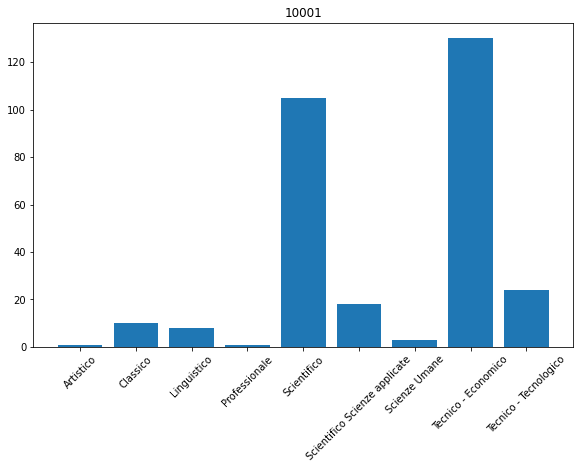

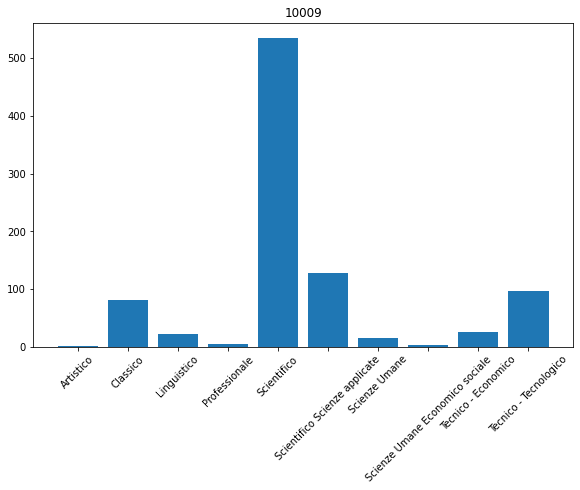

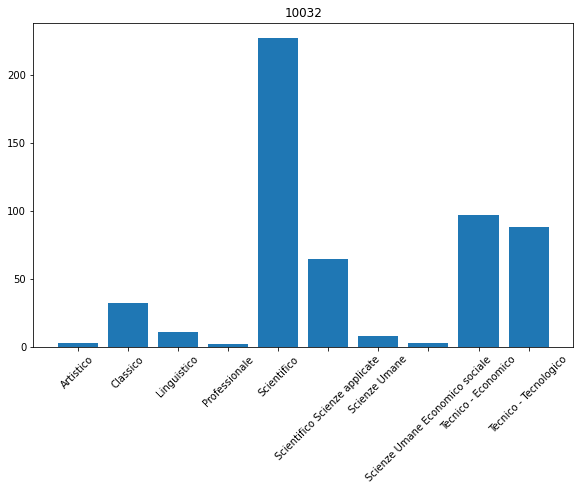

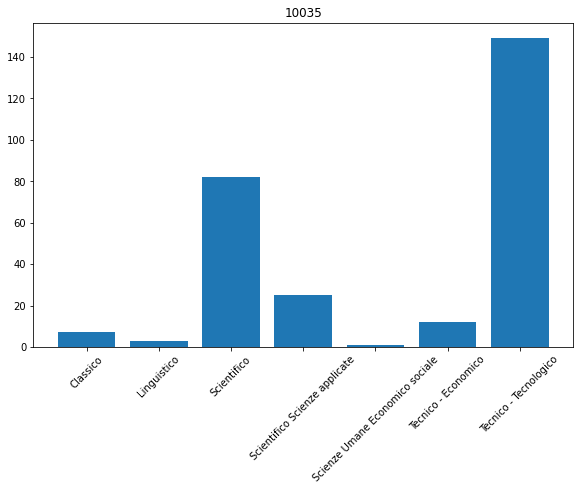

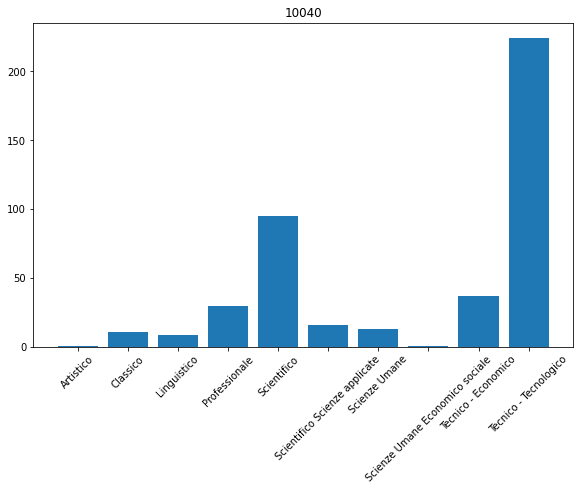

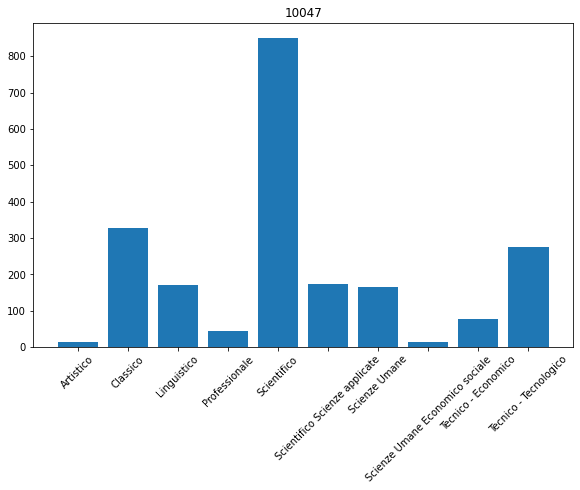

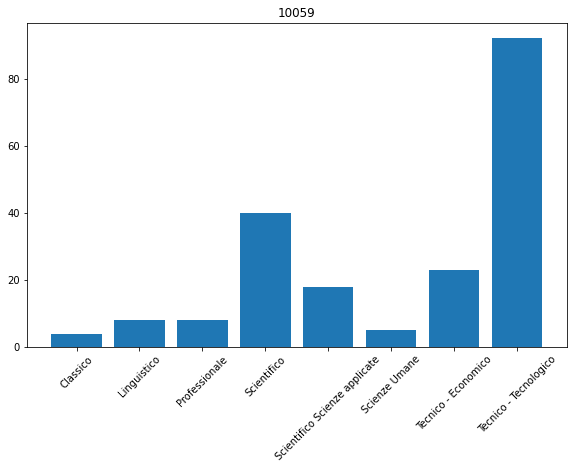

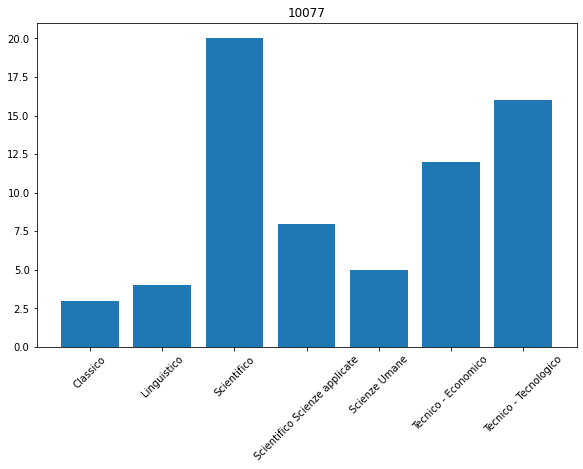

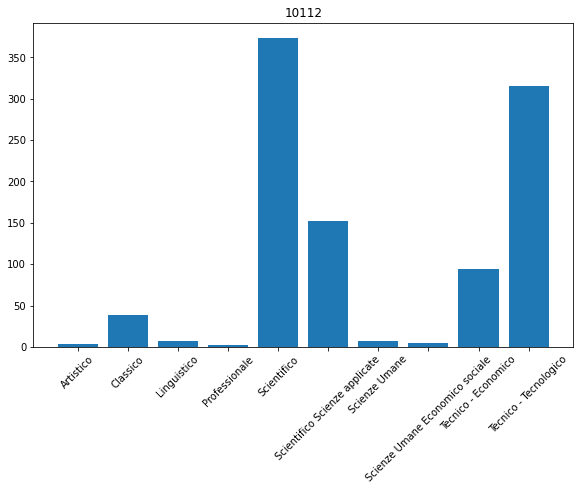

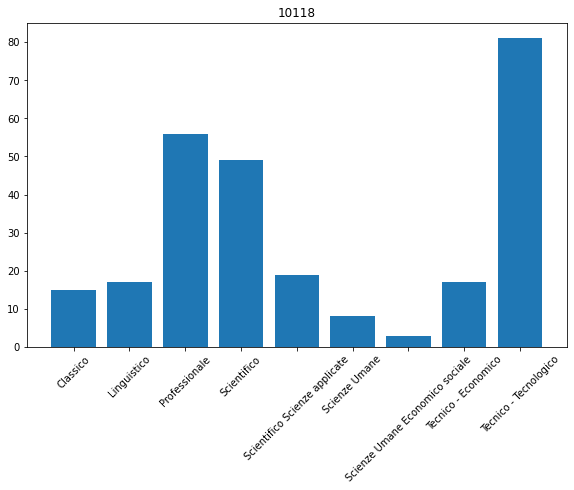

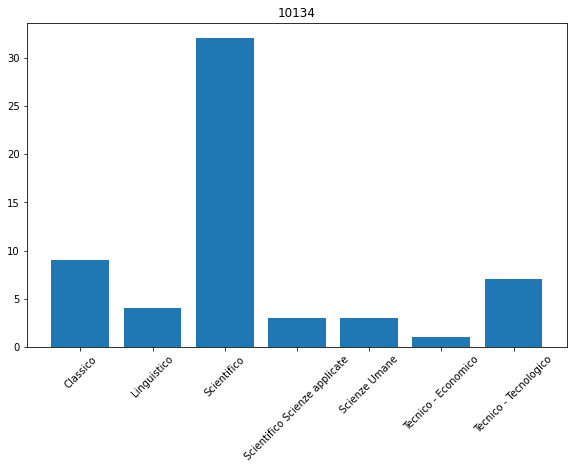

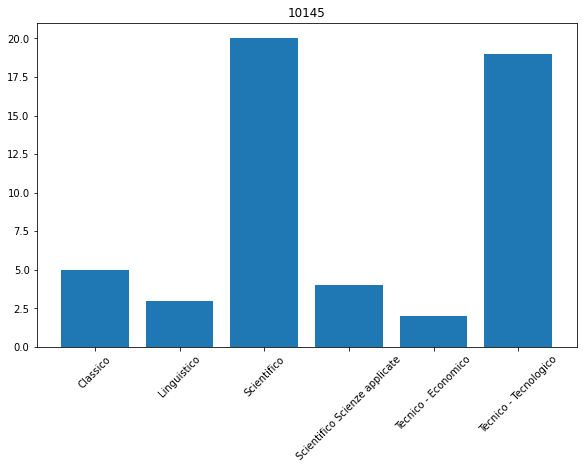

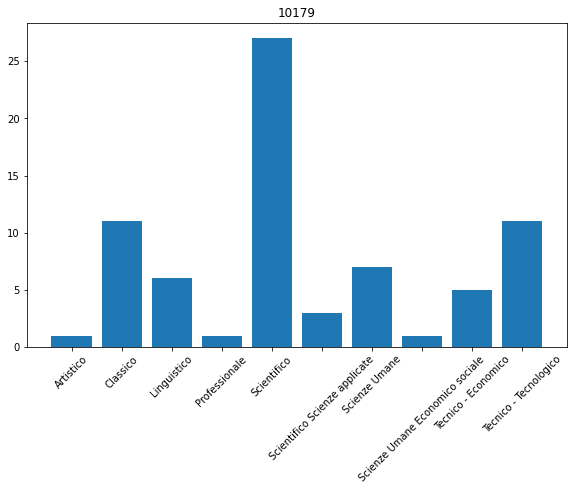

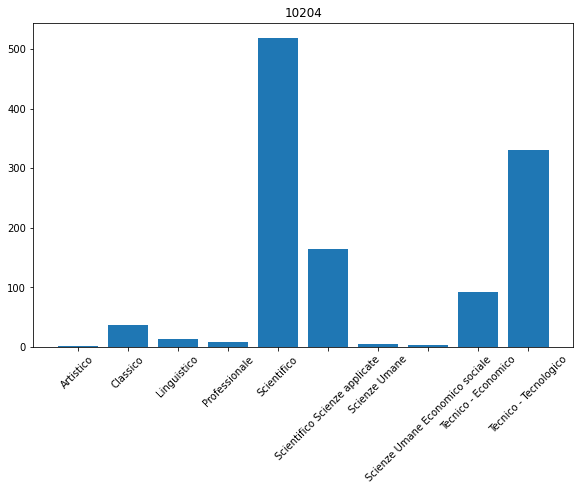

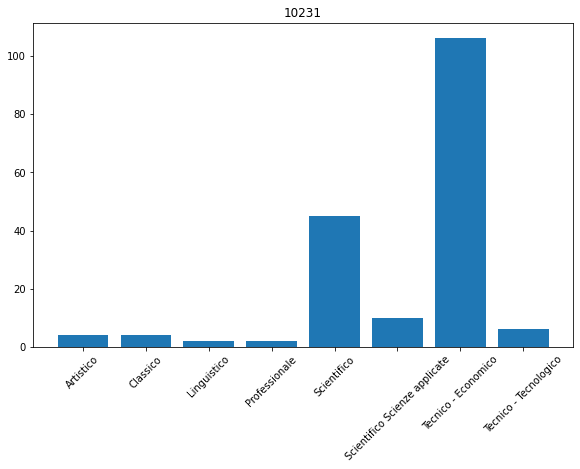

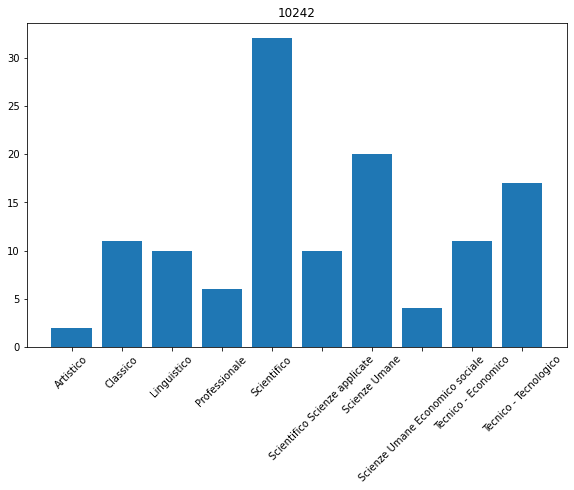

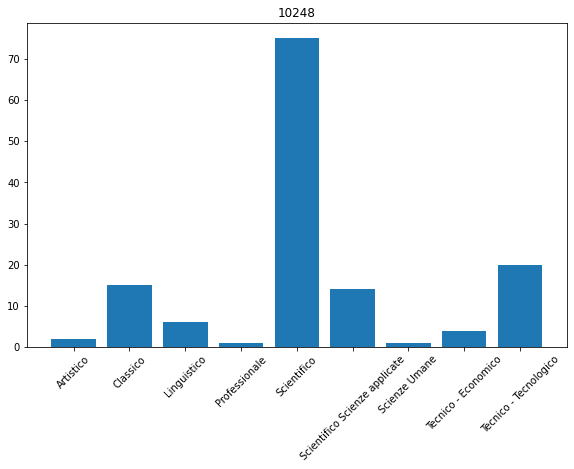

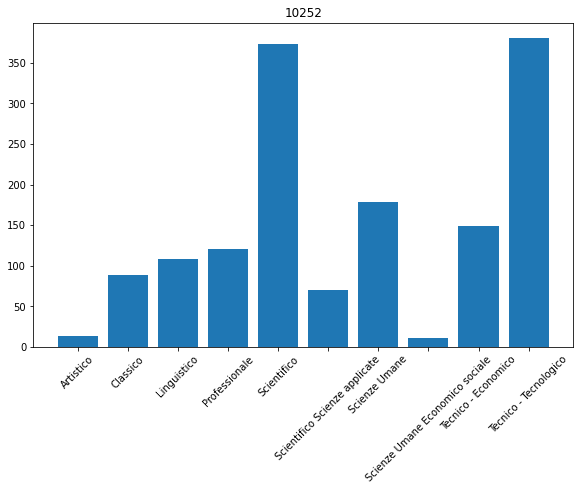

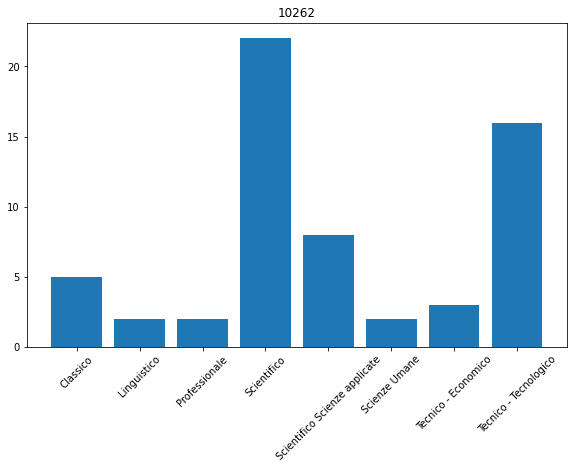

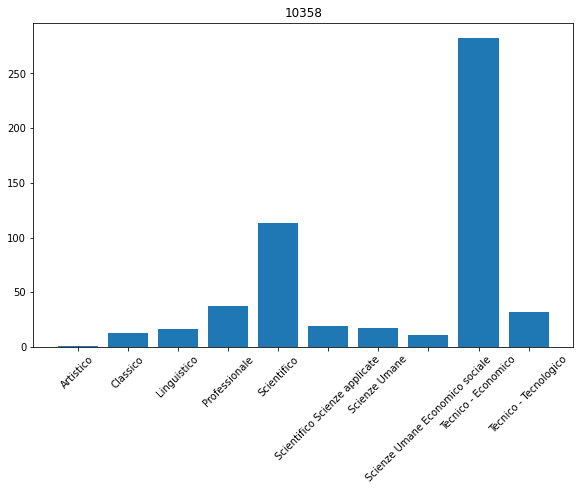

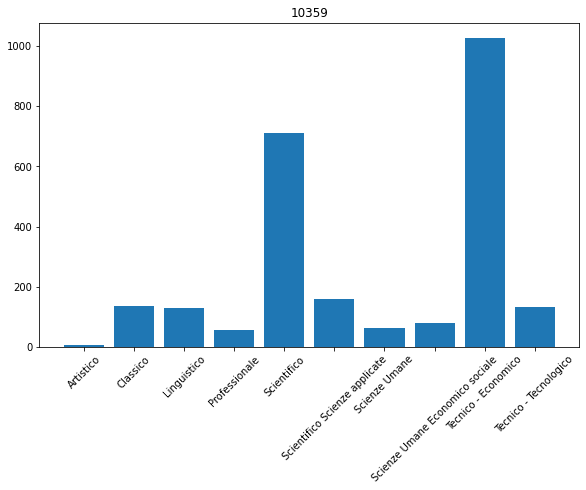

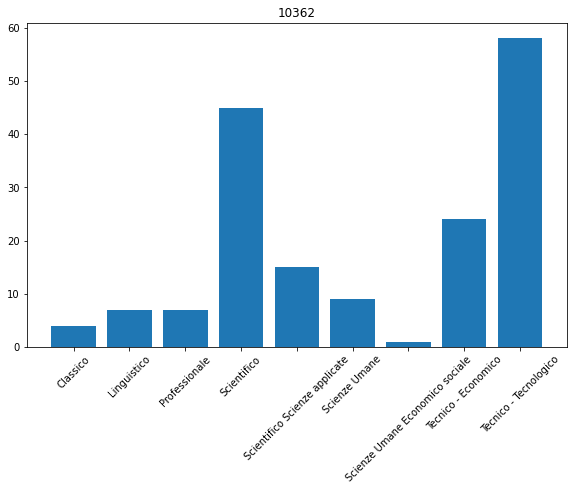

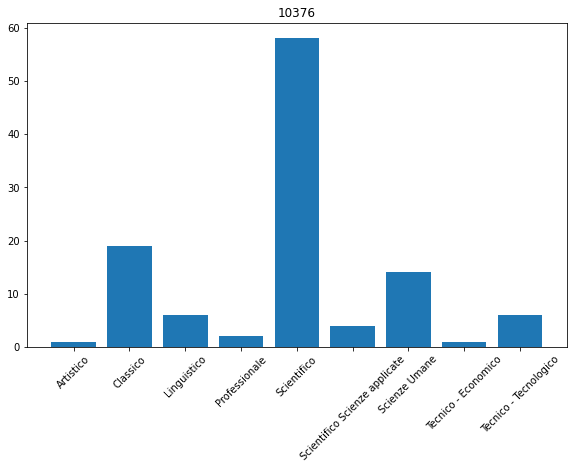

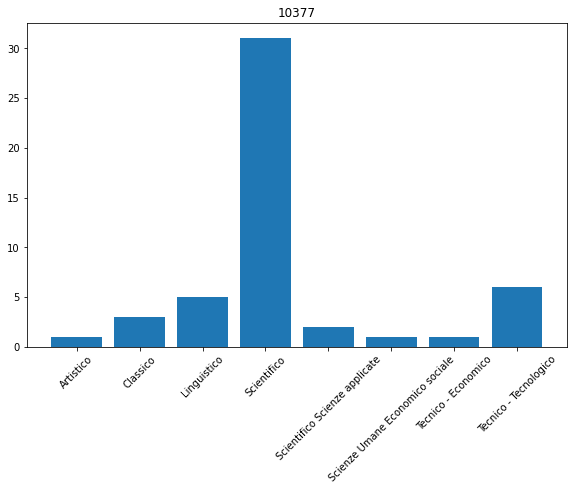

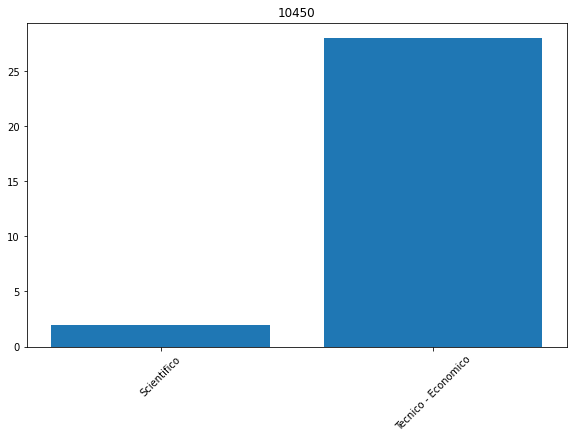

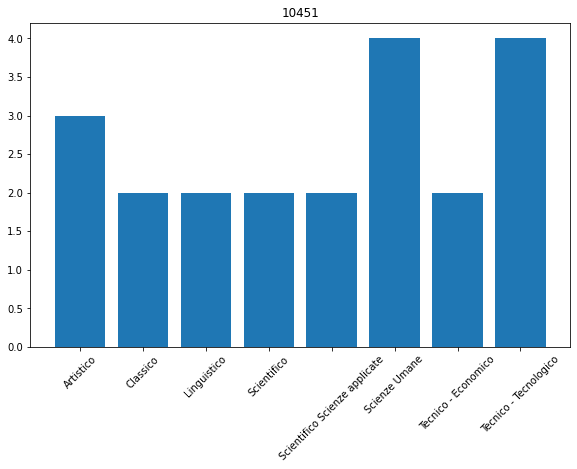

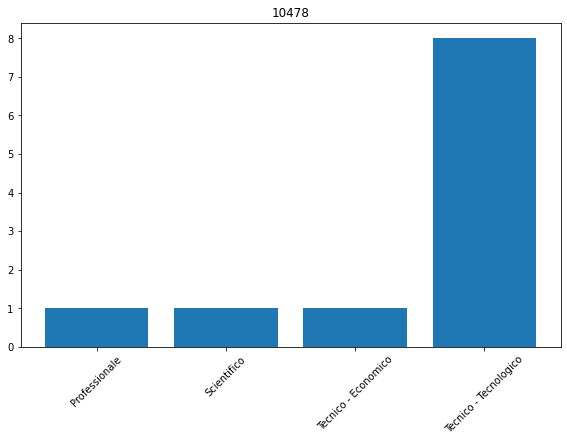

Text(0.5, 114.0, 'Scuole Superiori')

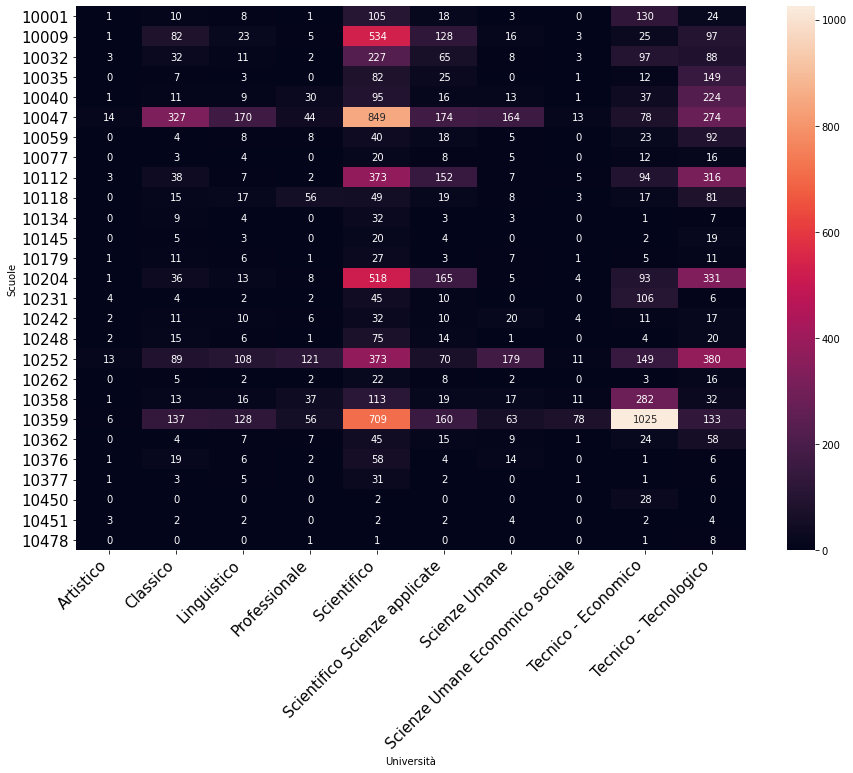

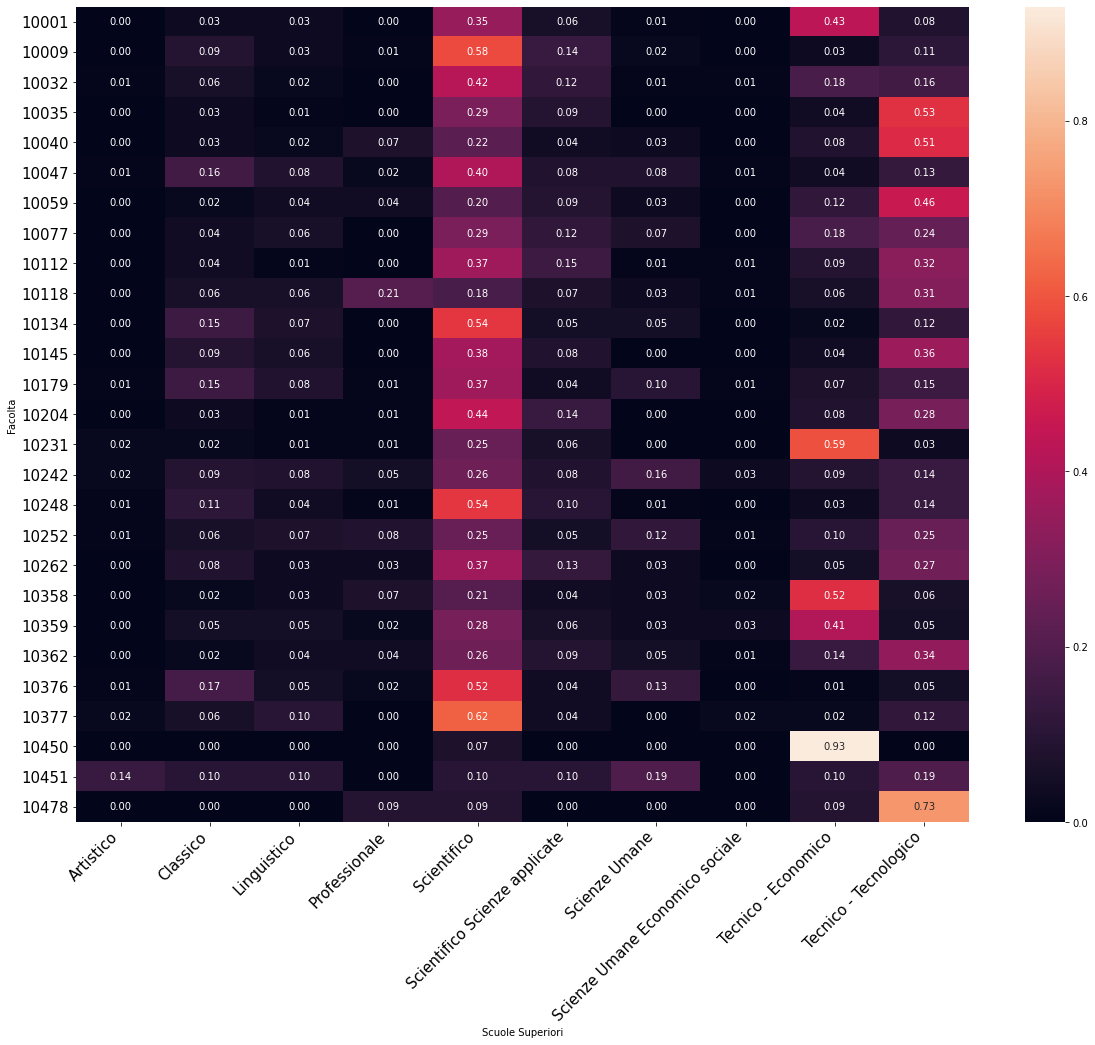

In [ ]:
matrice_confusione_iscritti_ss = pd.DataFrame(0,index=Tipologie_di_Facolta, columns=Tipologie_di_scuole)
matrice_confusione_confidenza_ss = pd.DataFrame(0.000,index=Tipologie_di_Facolta, columns=Tipologie_di_scuole)

k = 0
scuole = []
universita_t = []
for x in Tipologie_di_Facolta:
  n_iscritti_totale = 0
  tipo_facolta = x
  facolta = Facolta_Universita.get_group(x)
  #iscritti_CDS = scuola.groupby(scuola.CDS_IDL_)
  iscritti_SS = facolta.groupby(facolta.Tipo_EDUSCOPIO)
  scuola_superiore = iscritti_SS.groups.keys()
  #print(x); 
  #print(list(universita))
  n_iscritti_per_ss = np.empty(len(list(scuola_superiore)), dtype=object)
  k = 0
  for y in scuola_superiore:
    scuola_S = iscritti_SS.get_group(y)
    n_iscritti = scuola_S.shape[0]
    n_iscritti_per_ss[k] = n_iscritti
    matrice_confusione_iscritti_ss.at[x,y] = n_iscritti
    matrice_confusione_confidenza_ss.at[x,y] = n_iscritti
    k+=1
    n_iscritti_totale += n_iscritti
  for y in scuola_superiore:
    matrice_confusione_confidenza_ss.at[x,y] = round(matrice_confusione_confidenza_ss.at[x,y]/n_iscritti_totale,2)
  #print(list(scuola_superiore))  
  scuola_superiore_ = np.empty(len(list(scuola_superiore)), dtype=object)
  j = 0
  for x in list(scuola_superiore): 
    scuola_superiore_[j] = str(x)
    j+=1
  
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1]) 
  x_campo = list(scuola_superiore_)
  y_campo = n_iscritti_per_ss
  fig.set_size_inches(7.5, 4.5)
  ax.bar(x_campo,y_campo)
  plt.xticks(rotation=45)
  plt.title(tipo_facolta)
  plt.show()

plt.figure(figsize=(15, 10))
heatmap = sns.heatmap(matrice_confusione_iscritti_ss, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('Scuole')
plt.xlabel('Università')

plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(matrice_confusione_confidenza_ss, annot=True, fmt=".2f")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('Facolta')
plt.xlabel('Scuole Superiori')

# ANALISI RISULTATI UNIVERSITARI IN BASE ALLA PROVENIENZA 

Artistico
corso : 10001 , n_studenti : 1 , somma cfu : 36.0 , media cfu : 36.0 , somma voti : 26.25, media voto : 26.25 
corso : 10009 , n_studenti : 1 , somma cfu : 6.0 , media cfu : 6.0 , somma voti : 18.0, media voto : 18.0 
corso : 10032 , n_studenti : 3 , somma cfu : 42.0 , media cfu : 14.0 , somma voti : 63.0, media voto : 21.0 
corso : 10040 , n_studenti : 1 , somma cfu : 24.0 , media cfu : 24.0 , somma voti : 25.666667, media voto : 25.67 
corso : 10047 , n_studenti : 14 , somma cfu : 213.0 , media cfu : 15.21 , somma voti : 320.51666700000004, media voto : 22.89 
corso : 10112 , n_studenti : 3 , somma cfu : 84.0 , media cfu : 28.0 , somma voti : 64.466667, media voto : 21.49 
corso : 10179 , n_studenti : 1 , somma cfu : 23.0 , media cfu : 23.0 , somma voti : 29.714285999999998, media voto : 29.71 
corso : 10204 , n_studenti : 1 , somma cfu : 42.0 , media cfu : 42.0 , somma voti : 28.8, media voto : 28.8 
corso : 10231 , n_studenti : 4 , somma cfu : 72.0 , media cfu : 18.0 , so

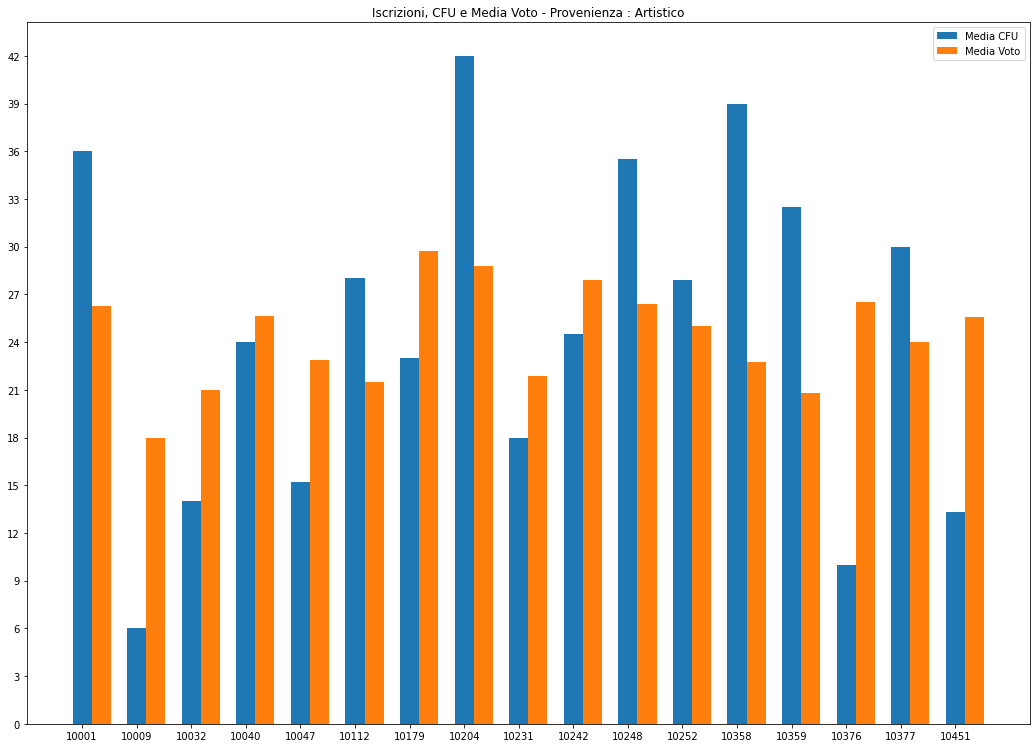

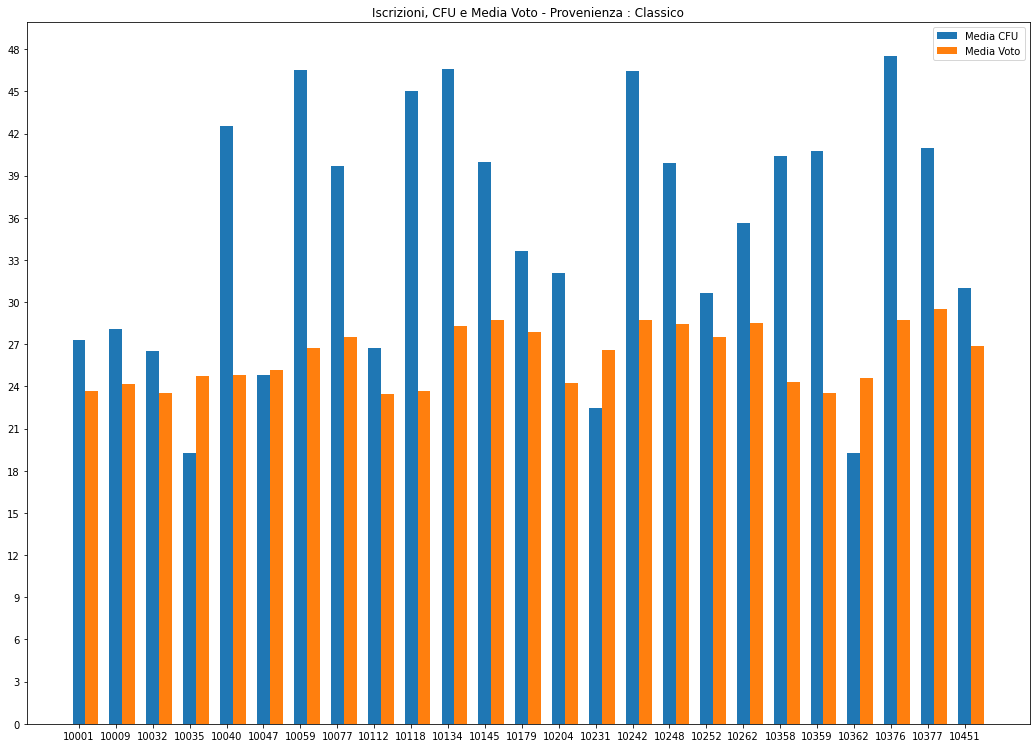

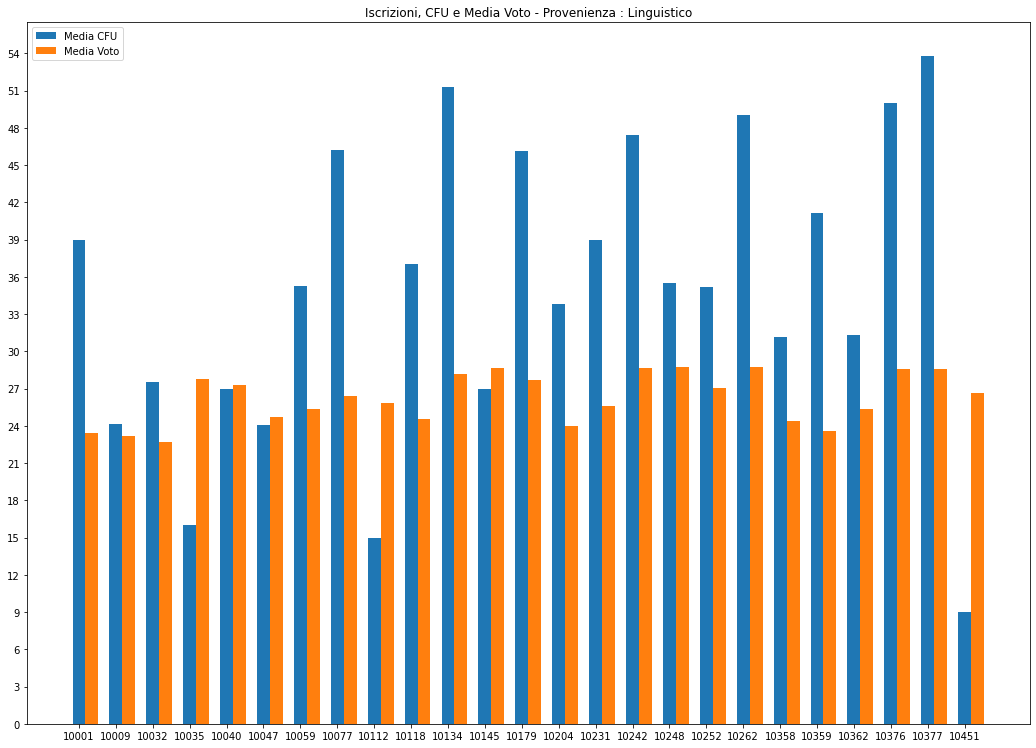

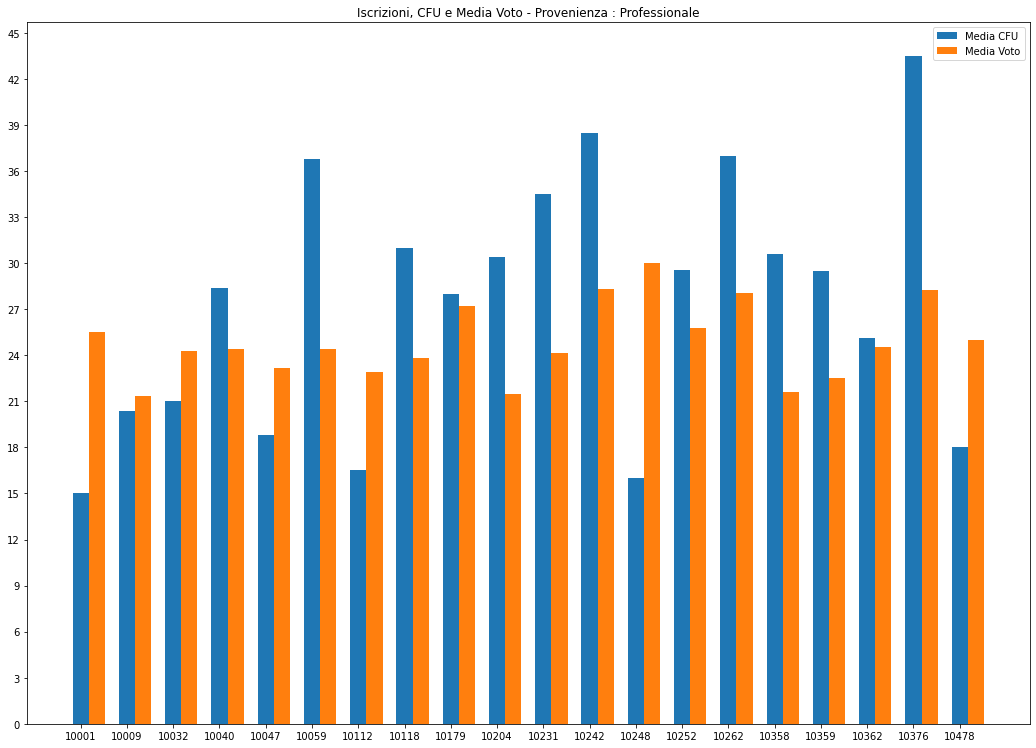

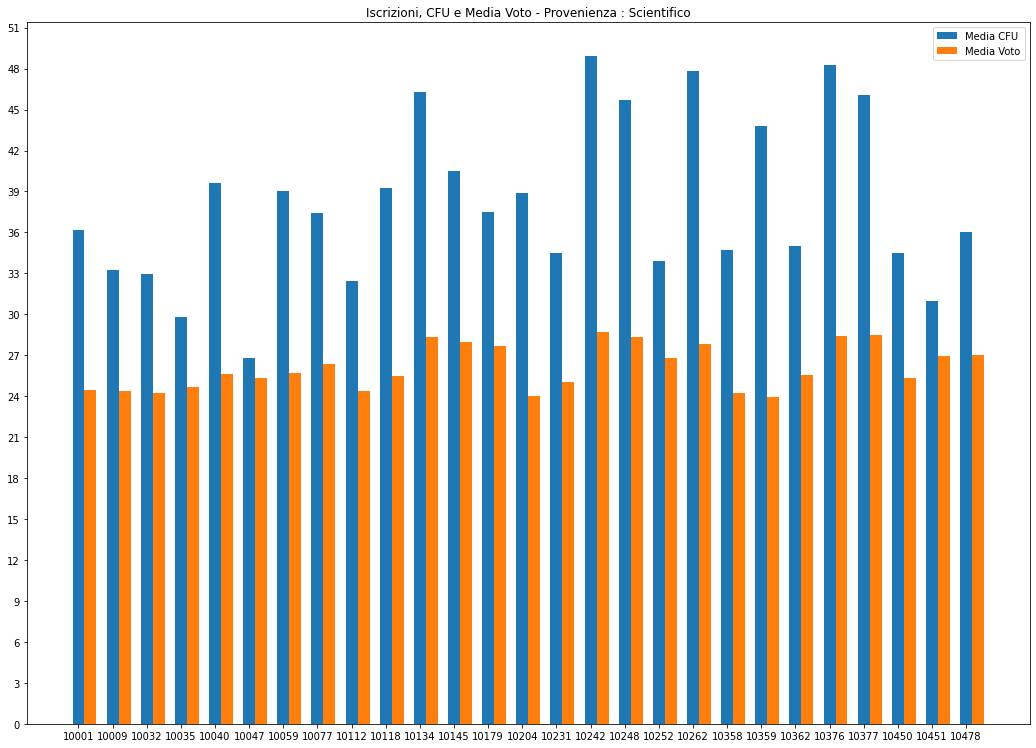

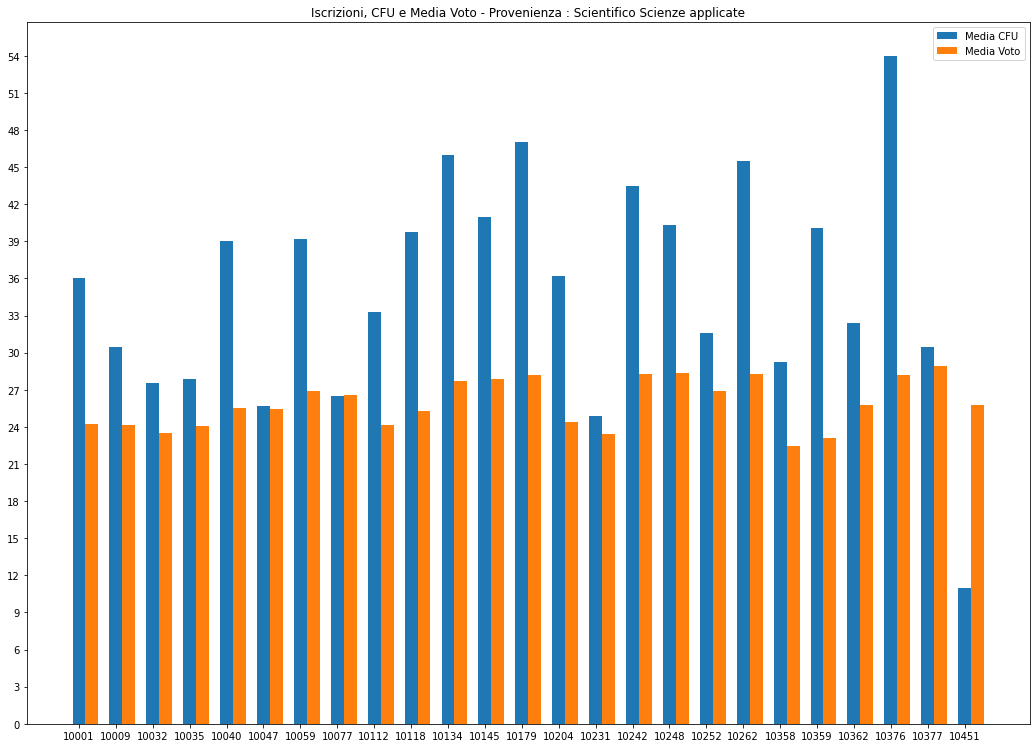

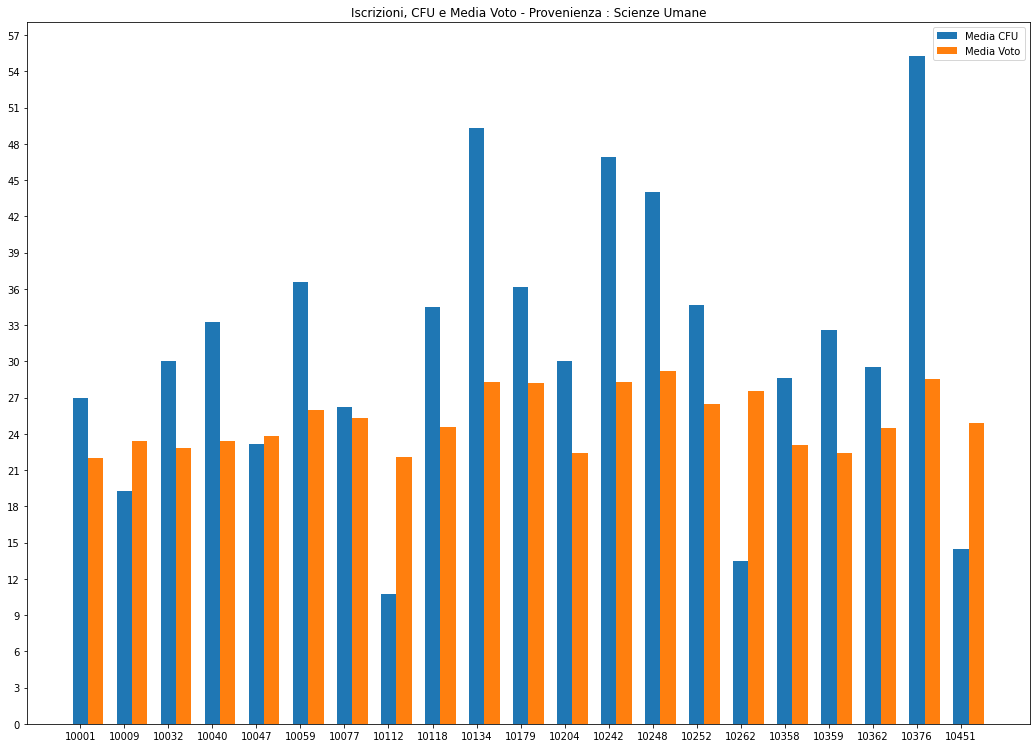

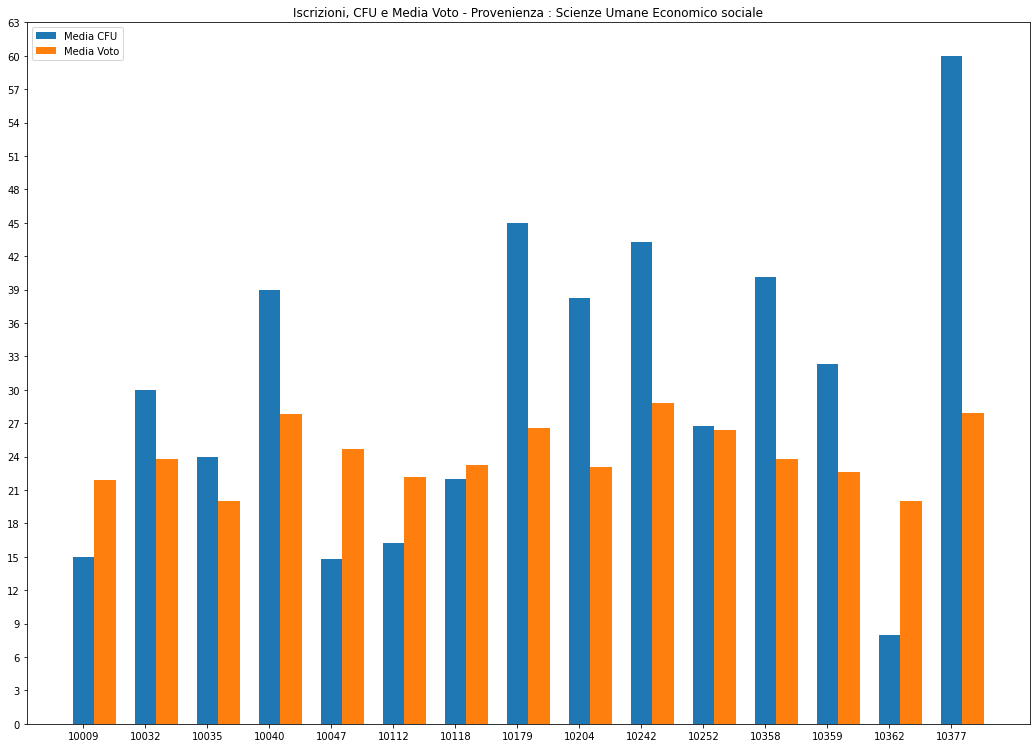

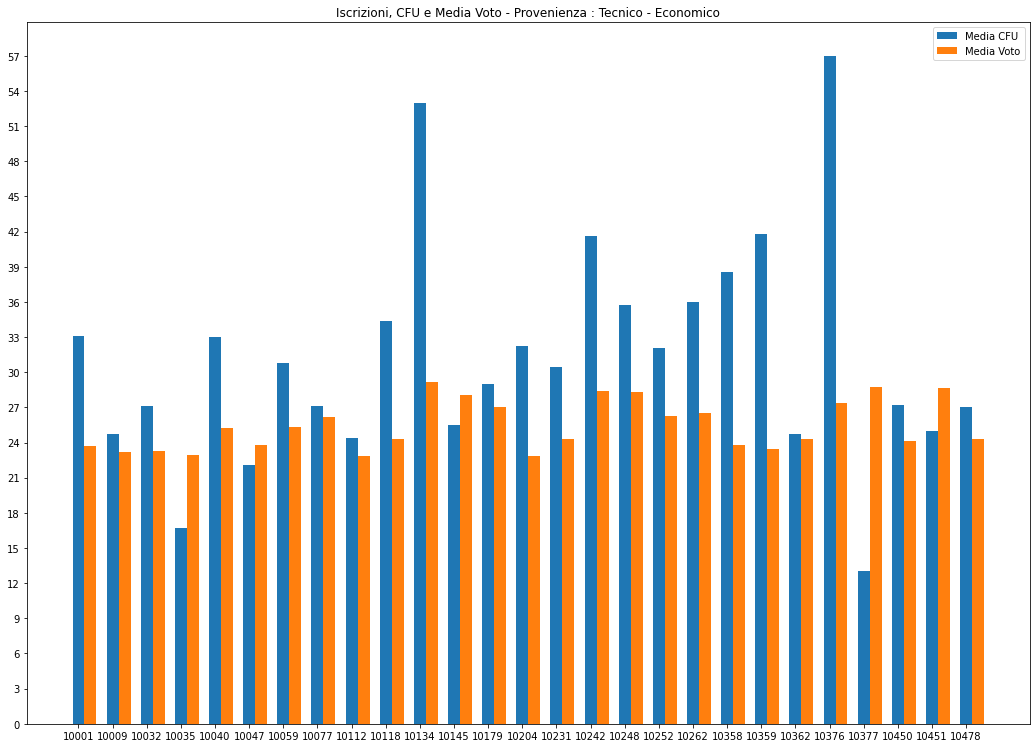

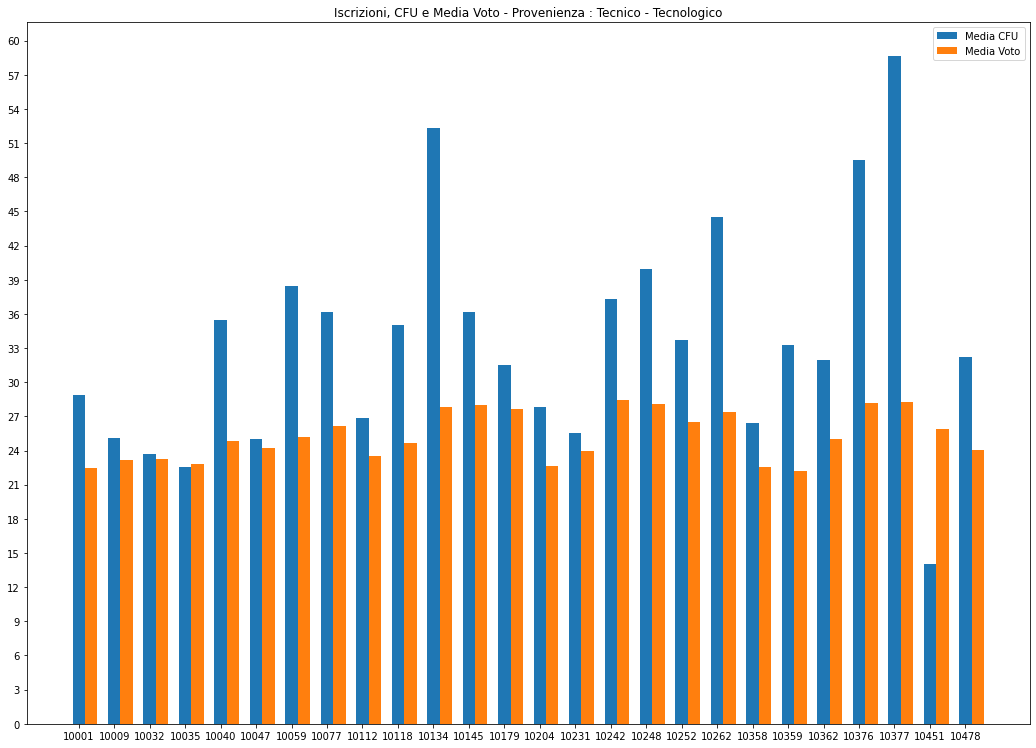

In [ ]:
Scuole_Superiori = DF_UNICO.groupby(DF_UNICO.Tipo_EDUSCOPIO)
Tipologie_di_scuole = Scuole_Superiori.groups.keys(); 


result2 = pd.DataFrame(columns=['corso', 'tipo_scuola', 'n_iscrizione', 'media_cfu', 'media_voto'])
n = 0;
val_scuola_ = list()
for tipo_scuola in list(Tipologie_di_scuole):
      scuola = Scuole_Superiori.get_group(tipo_scuola)
      iscritti_CDS = scuola.groupby(scuola.CDS_ID_x)
      universita = iscritti_CDS.groups.keys(); 
      print(tipo_scuola)
      for corso in list(universita):
        somma_CFU = 0;
        iscritti = iscritti_CDS.get_group(corso)
        somma_CFU =  iscritti['sum(PESO_AD)'].sum();
        n_iscrizione = iscritti.MATRICOLA.nunique();
        media_cfu = round(somma_CFU/n_iscrizione,2)
        media_voto = round(((iscritti['AVG(VOTO)'].sum()/n_iscrizione)),2)
        print('corso : {} , n_studenti : {} , somma cfu : {} , media cfu : {} , somma voti : {}, media voto : {} '.format(corso, n_iscrizione, somma_CFU, media_cfu,iscritti['AVG(VOTO)'].sum(), media_voto))
        result2 = result2.append({'corso' : str(corso), 'tipo_scuola' : tipo_scuola, 'n_iscrizione' : n_iscrizione, 'media_cfu' : media_cfu, 'media_voto': media_voto}, ignore_index=True)

result2 = result2.groupby(by='tipo_scuola')

for tipo_g_scuola in list(Tipologie_di_scuole):
  result = result2.get_group(tipo_g_scuola)

  labels = result['corso']
  media_cfu_g = result['media_cfu']
  media_voto_g = result['media_voto']

  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  fig.set_size_inches(14.5, 10.5)
  plt.yticks(np.arange(0, 3000, 3))
  #rects1 = ax.bar(x - width, n_iscrizioni_g, width, label='Iscrizioni')
  rects1 = ax.bar(x , media_cfu_g, width, label='Media CFU')
  rects2 = ax.bar(x + width, media_voto_g, width, label='Media Voto')


  ax.set_title('Iscrizioni, CFU e Media Voto - Provenienza : {}'.format(tipo_g_scuola))
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()


    

# ANALISI RISULTATI UNIVERSITÀ (TEMPESTICHE) DATA PROVENIENZA

In [ ]:
Scuole_Superiori = DF_UNICO.groupby(DF_UNICO.Tipo_EDUSCOPIO)
Tipologie_di_scuole = Scuole_Superiori.groups.keys(); 

DF_UNICO.to_csv("appelli.csv")
result_date = pd.DataFrame(columns=['corso', 'tipo_scuola','MIN_DATA', 'MAX_DATA', 'DAY_DIFF'])
n = 0;
val_scuola_ = list()

for tipo_scuola in list(Tipologie_di_scuole):
      scuola = Scuole_Superiori.get_group(tipo_scuola)
      iscritti_CDS = scuola.groupby(scuola.CDS_ID_x)
      universita = iscritti_CDS.groups.keys(); 

      for corso in list(universita):
        somma_CFU = 0;
        iscritti = iscritti_CDS.get_group(corso)
        try:
          max_data = datetime.strptime(iscritti['min(DATA_SUP)'].iloc[0], '%Y-%m-%d %H:%M:%S')
          min_data = datetime.strptime(iscritti['min(DATA_SUP)'].iloc[0], '%Y-%m-%d %H:%M:%S')
          for index, row in iscritti.iterrows():
            try:
              date = datetime.strptime(row['min(DATA_SUP)'], '%Y-%m-%d %H:%M:%S')
              str_anno_accademico = '{}-{}-{} {}:{}:{}'.format(row['AA_ISCR_ID']+1,1,8,'00','00','00')
              date_anno_accademico = datetime.strptime(str_anno_accademico, '%Y-%m-%d %H:%M:%S') 
              giorni_diff =  (date-date_anno_accademico).days
            except:
              print("Errore Calcolo DIFF")
          
            if date < min_data:
              min_data = date
            if max_data < date:
              max_data = date

            result_date = result_date.append({'corso' : corso, 'tipo_scuola' : tipo_scuola, 'MIN_DATA' : min_data, 'MAX_DATA' : max_data, 'DAY_DIFF' : giorni_diff}, ignore_index=True)

        except:
          print("Calcolo Non riuscito")

result_date.to_csv("a.csv")
result_grafico = pd.DataFrame(columns=['corso', 'scuola', 'MONTH_DIFF_AVG'])
result_date_scuole = result_date.groupby(by='tipo_scuola')

for tipo_g_scuola in list(Tipologie_di_scuole):
  result_date_scuola = result_date_scuole.get_group(tipo_g_scuola)

  result_date_scuola_universita = result_date_scuola.groupby(by='corso')
  universita = result_date_scuola_universita.groups.keys(); 
  for corso in universita:
    result_corso = result_date_scuola_universita.get_group(corso)

    
    day_diff_sum = result_corso['DAY_DIFF'].sum(); 
    n_iscritti_g = result_corso['DAY_DIFF'].count(); 
    day_diff_avg = round(day_diff_sum / n_iscritti_g,2)
    month_diff_avg = round(day_diff_avg / 30,0)
    #print('Corso : {} - Tipo Scuola : {} - DAY DIFF SUM : {} - DAY DIFF AVG : {} - MONTH DIFF {} - N° Iscritti : {}'.format(corso , tipo_g_scuola,  day_diff_sum, day_diff_avg, month_diff_avg,n_iscritti_g))
    result_grafico = result_grafico.append({'corso' : str(corso), 'scuola' : tipo_g_scuola, 'MONTH_DIFF_AVG' : month_diff_avg}, ignore_index=True)


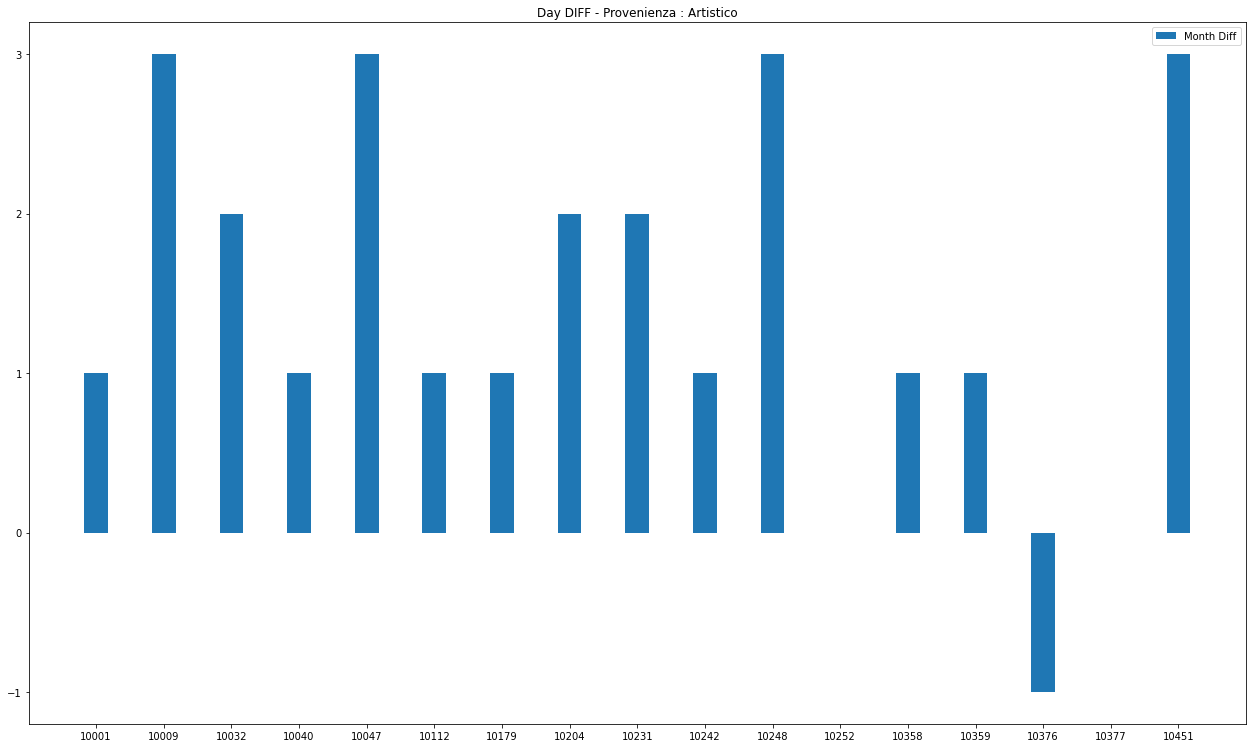

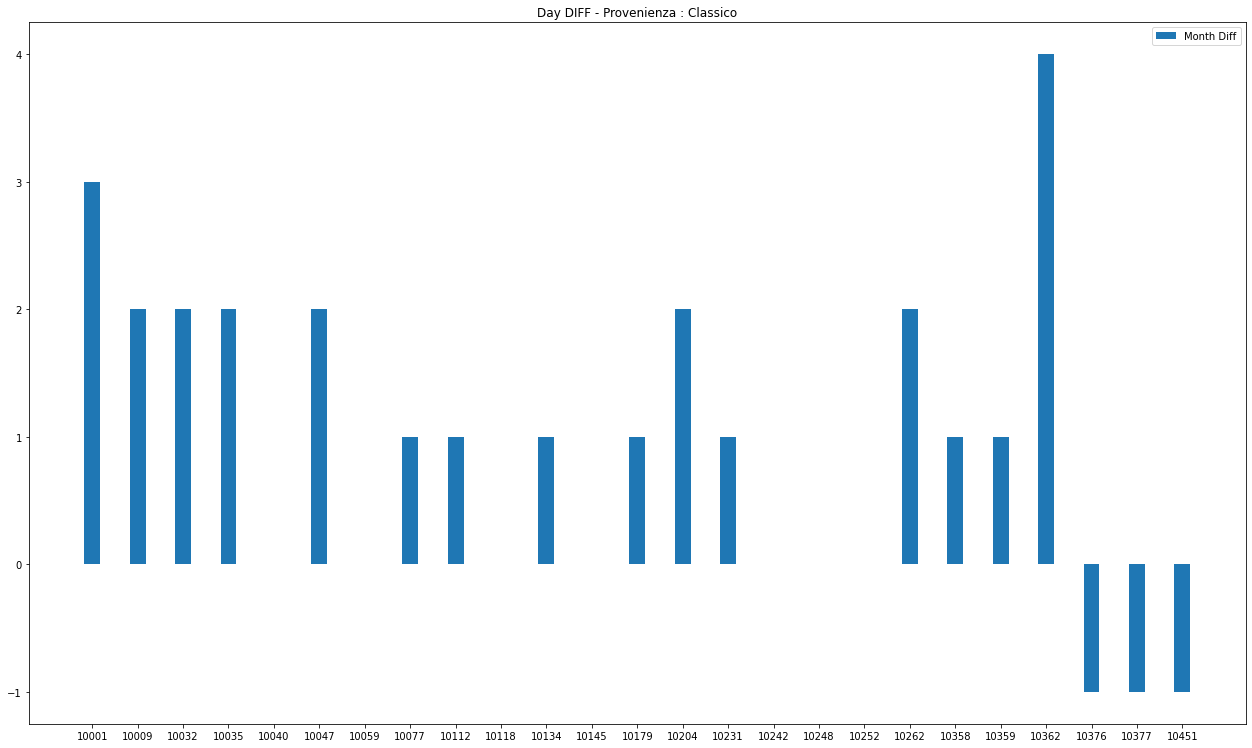

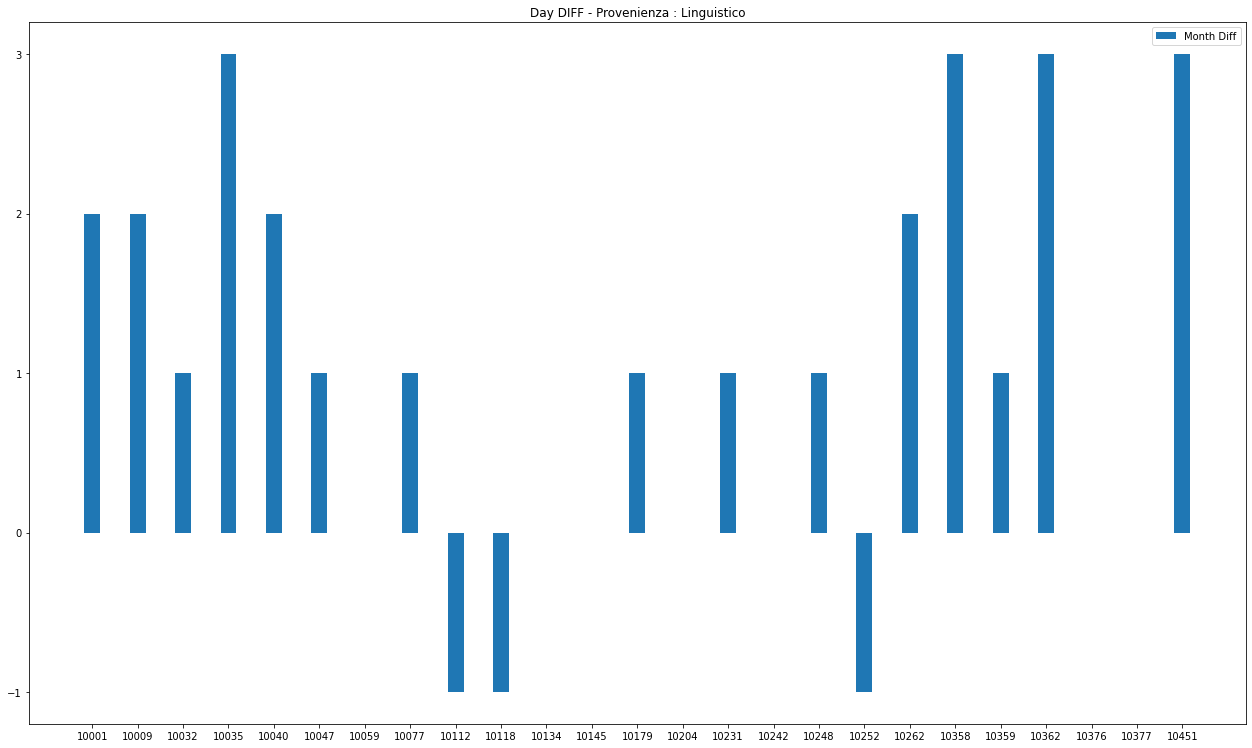

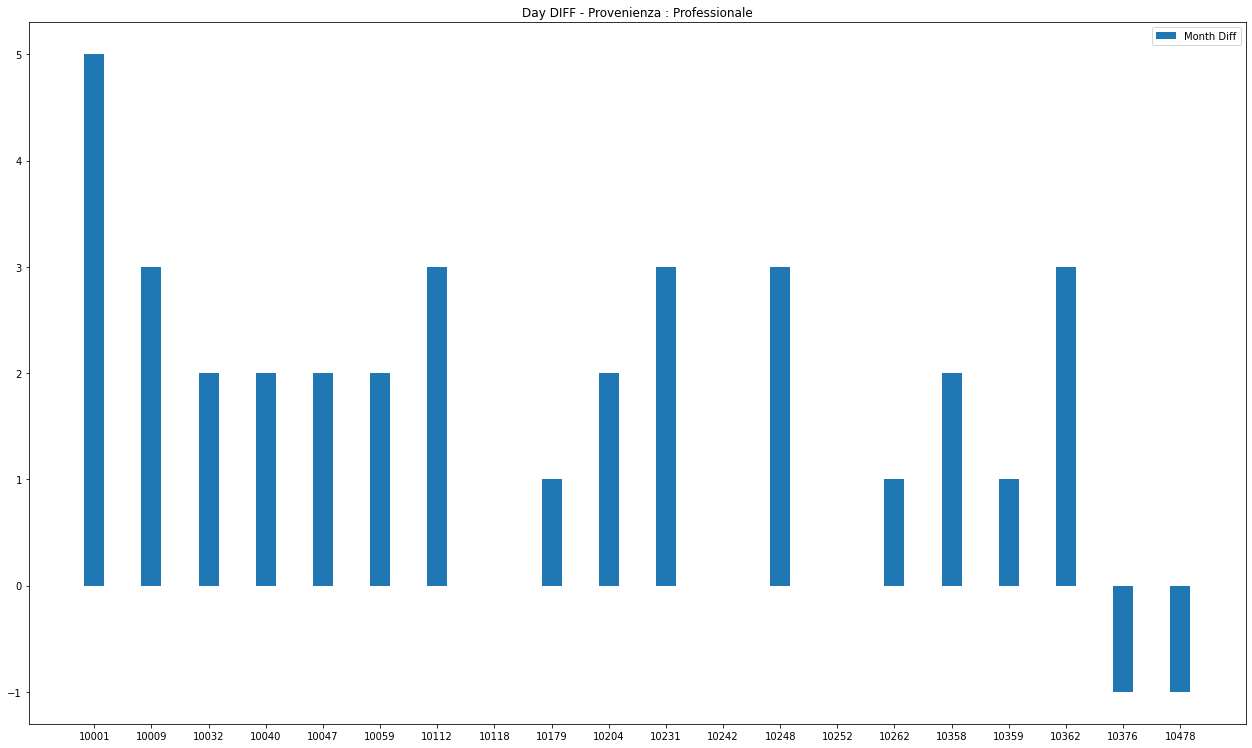

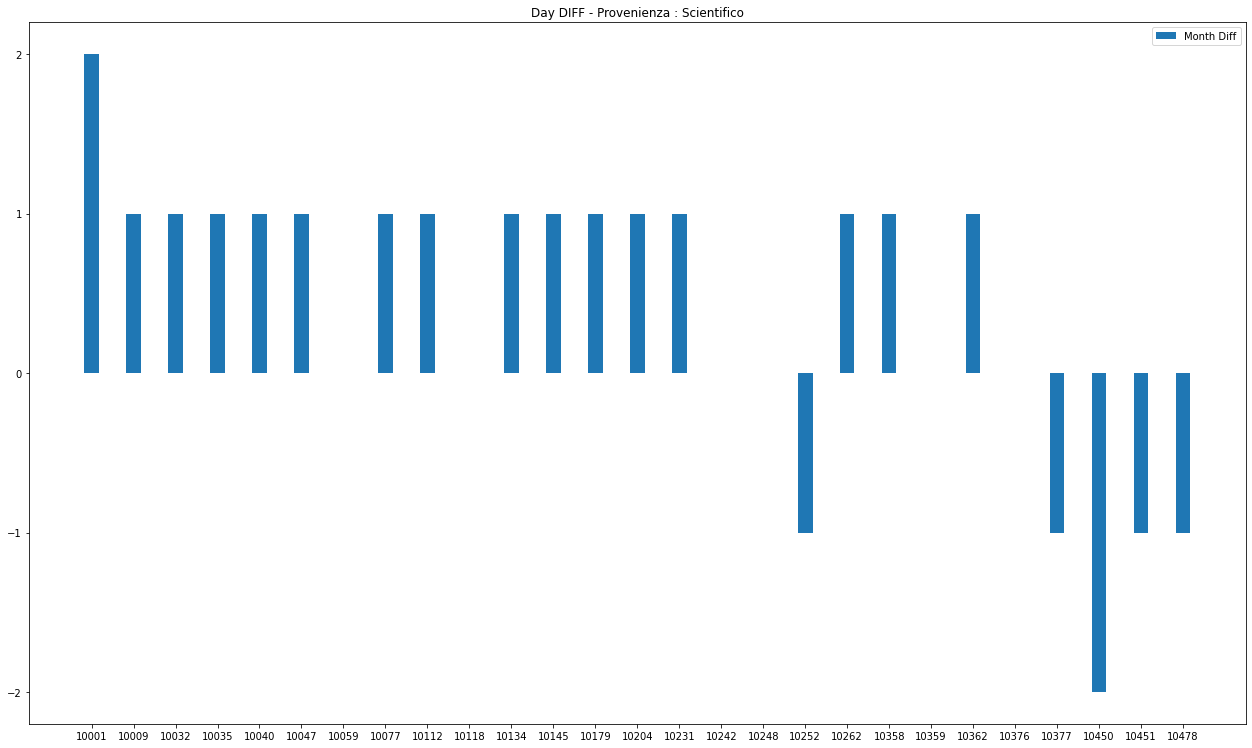

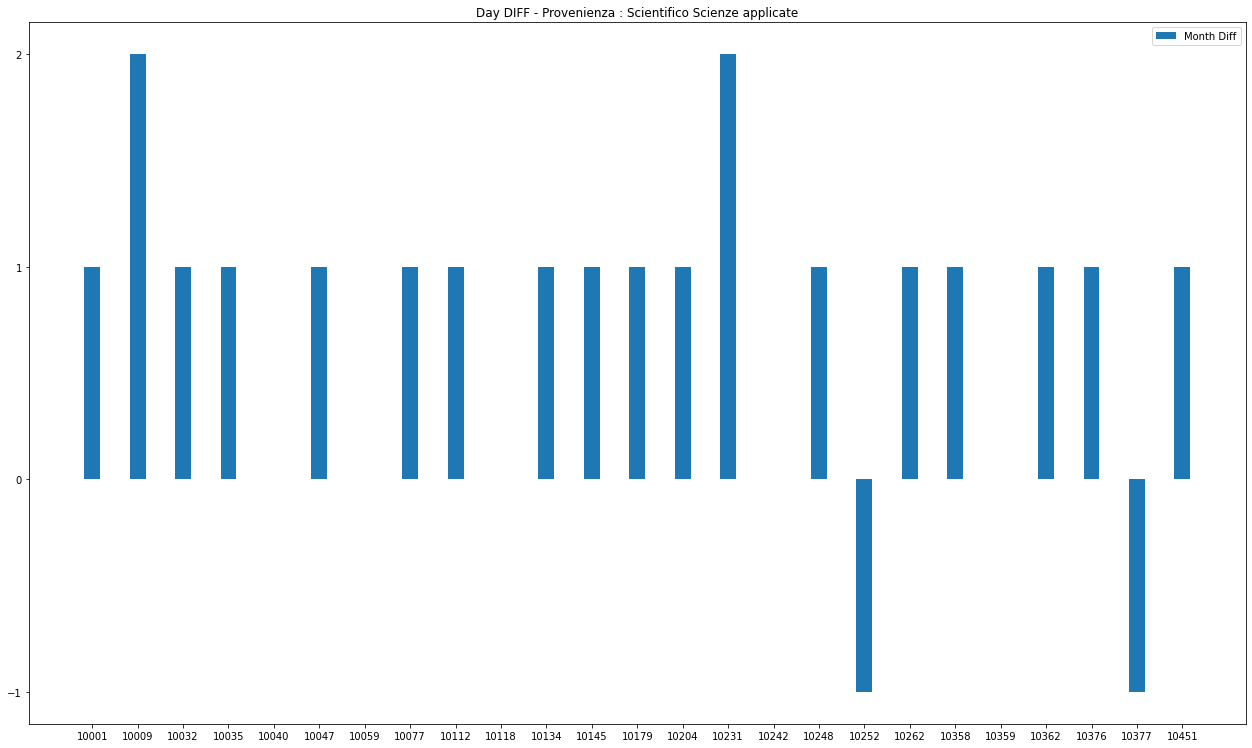

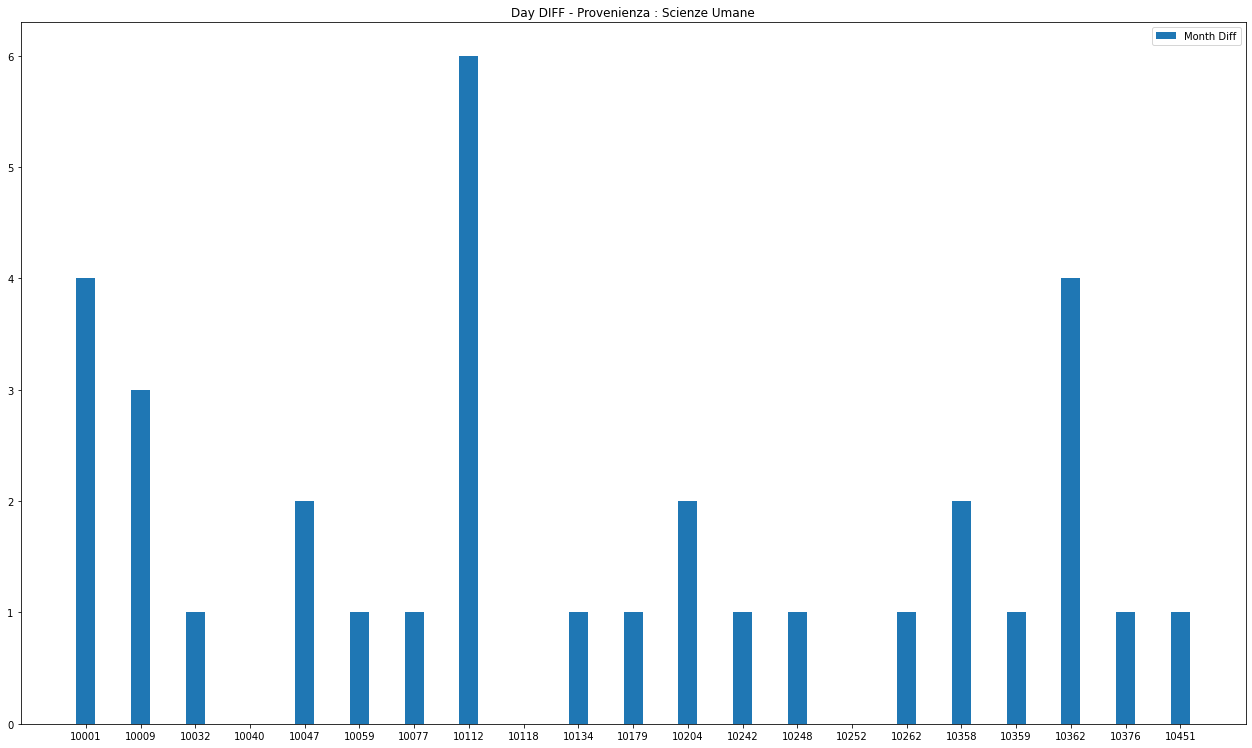

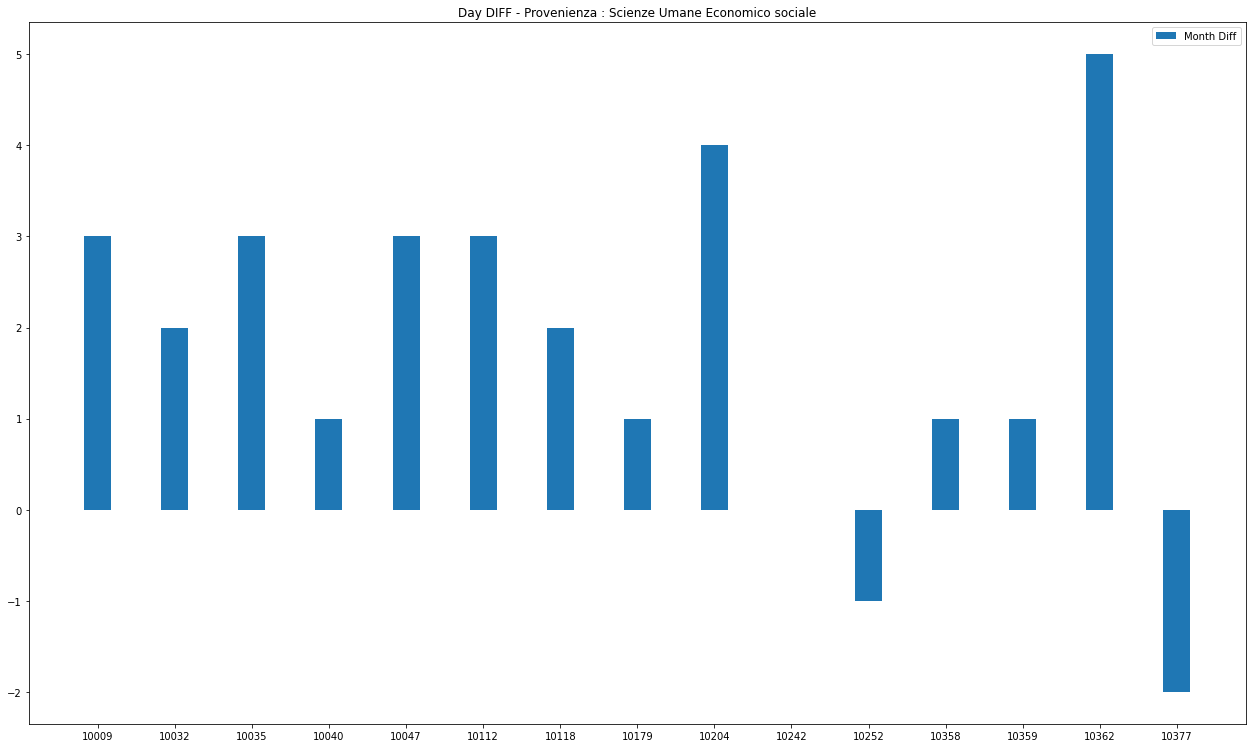

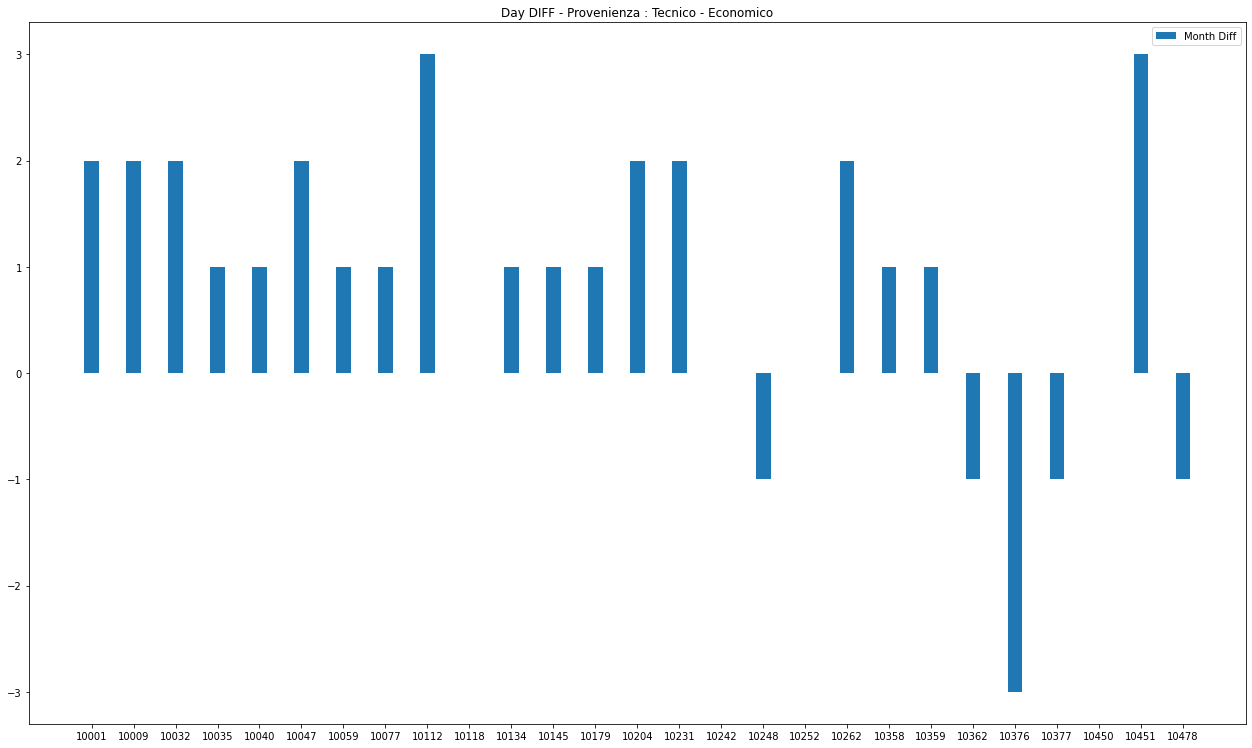

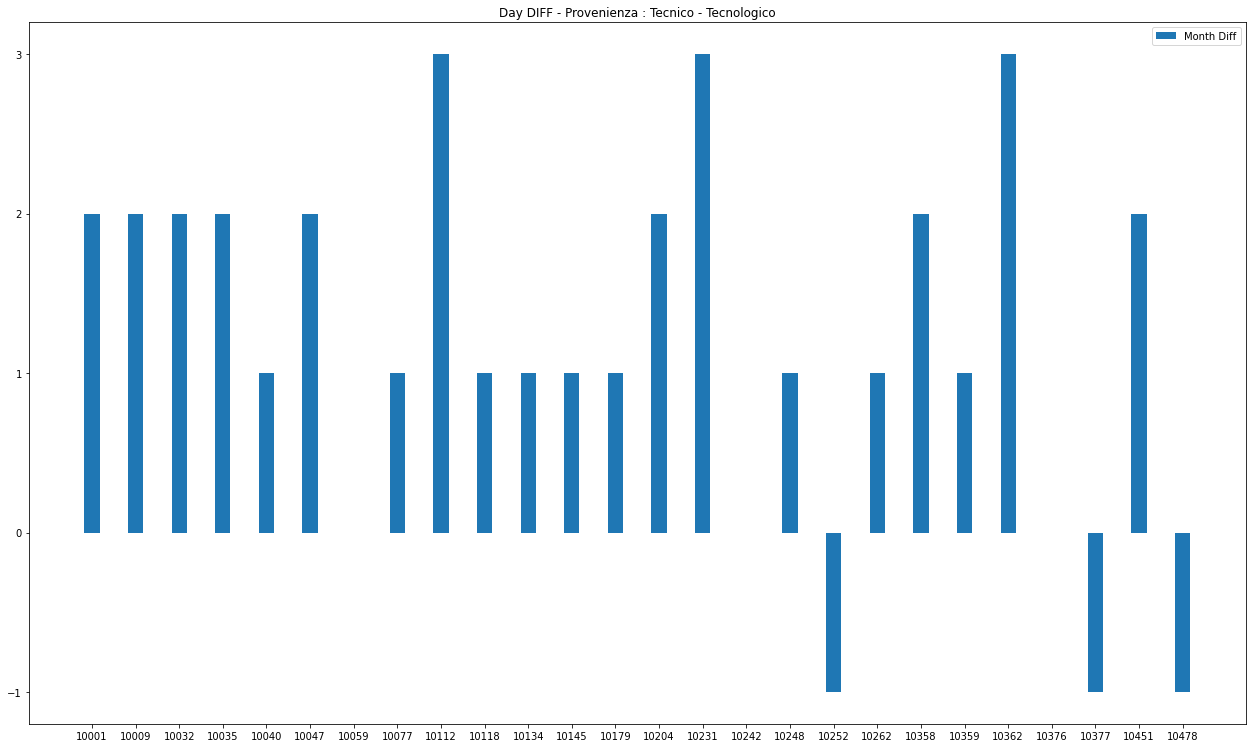

In [ ]:
#result_grafico = result_grafico.append({'corso' : str(corso), 'scuola' : tipo_g_scuola, 'DAY_DIFF_AVG' : day_diff_avg}, ignore_index=True)

result_g_g = result_grafico.groupby(by='scuola')
for tipo_g_scuola in list(Tipologie_di_scuole):
  result = result_g_g.get_group(tipo_g_scuola)

  labels = result['corso']
  #n_iscrizioni_g = result['n_iscrizione']
  day_diff = result['MONTH_DIFF_AVG']
  

  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  fig.set_size_inches(17.5, 10.5)
  plt.yticks(np.arange(-24, +24, 1))
  #rects1 = ax.bar(x - width, n_iscrizioni_g, width, label='Iscrizioni')
  rects1 = ax.bar(x , day_diff, width, label='Month Diff')
  


  ax.set_title('Day DIFF - Provenienza : {}'.format(tipo_g_scuola))
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()

# ANALISI CAMBIAMENTI DI PERCORSO

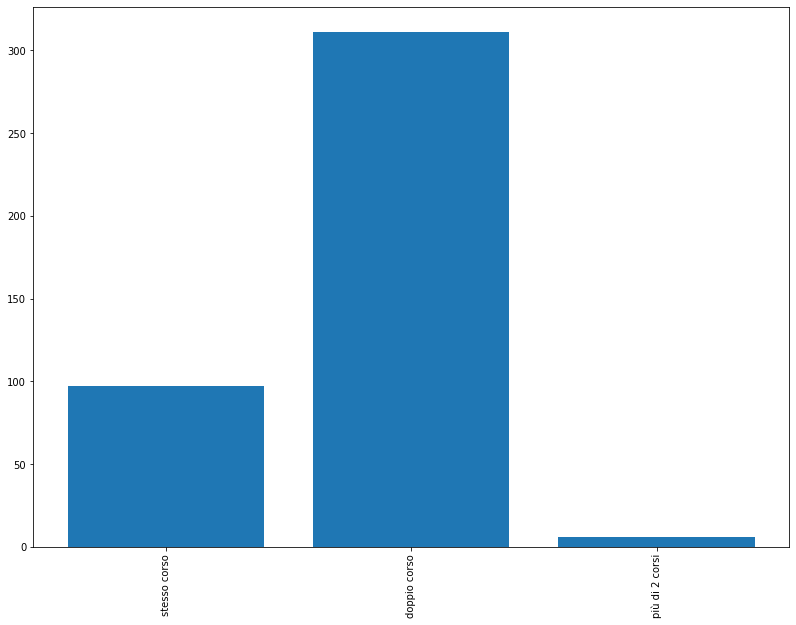

In [ ]:
DF_iscritti_analisi = DF_iscritti.copy()

DF_cambiamenti = pd.DataFrame(columns=['persona_id', 'corso'])

for index, row in DF_iscritti_analisi.iterrows():
  persona_id = row['PERS_ID']
  count_iscrizioni_persona =  len(DF_iscritti_analisi[(DF_iscritti_analisi['PERS_ID'] == (persona_id))]) 
  if count_iscrizioni_persona > 1:
    DF_cambiamenti = DF_cambiamenti.append({'persona_id' : persona_id , 'corso' : str(row['CDS_ID'])}, ignore_index=True)


result_DF_cambiamenti = DF_cambiamenti.groupby(by='persona_id')
persone = result_DF_cambiamenti.groups.keys();

stesso_corso = 0
doppio_corso = 0
piu_corso = 0

for persona in list(persone):
  result_DF_cambiamenti_persona = result_DF_cambiamenti.get_group(persona)
  n_corsi = result_DF_cambiamenti_persona['corso'].nunique();
  if n_corsi == 1: 
    stesso_corso = stesso_corso +1 ;
  elif n_corsi == 2: 
    doppio_corso += 1
  elif n_corsi > 2: 
    piu_corso += 1

#print("Stesso corso : {} - Doppio Corso : {} - Più Corsi : {}".format(stesso_corso,doppio_corso,piu_corso))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1]) 
x_campo = ['stesso corso', 'doppio corso' , 'più di 2 corsi']
y_campo = [stesso_corso, doppio_corso, piu_corso]
fig.set_size_inches(10.5, 7.5)
ax.bar(x_campo,y_campo)
plt.xticks(rotation=90)
plt.show()


# ANALISI DOPPI DIPLOMI (NON RILEVANTE) 


TOTALE CAMBIAMENTI : 839 


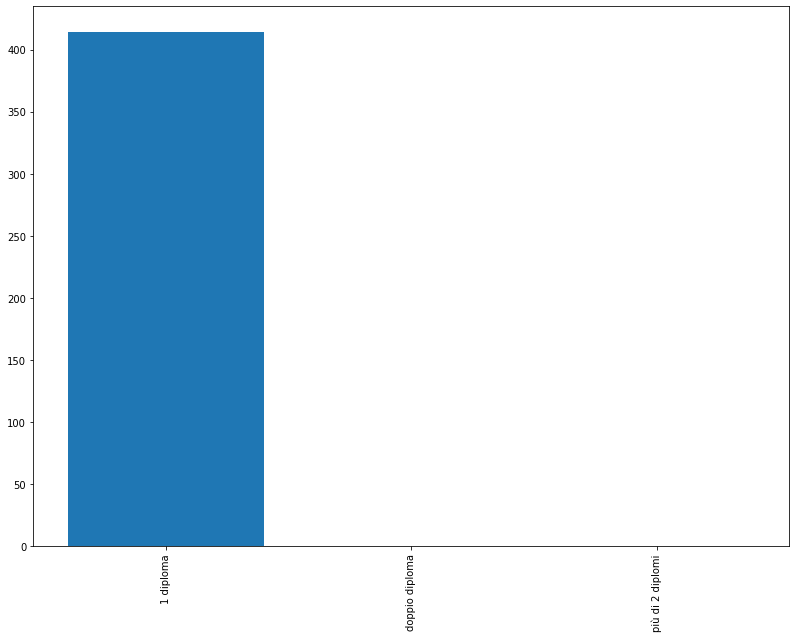

In [ ]:
DF_iscritti_analisi_doppi_diplomi = DF_iscritti.copy()

DF_doppi_diplomi = pd.DataFrame(columns=['persona_id', 'scuola', 'diploma'])

for index, row in DF_iscritti_analisi.iterrows():
  persona_id = row['PERS_ID']
  scuola = row['MIUR_SCUOLE_COD']
  scuola_diploma = row['Tipo_EDUSCOPIO']
  anno_conseguimento = row['AA_CONSEG_TITOLO']
  #count_diplomi_persona =  len(DF_iscritti_analisi_doppi_diplomi[( (DF_iscritti_analisi_doppi_diplomi['PERS_ID'] == (persona_id)) & 
  #                                                                   (DF_iscritti_analisi_doppi_diplomi['Tipo_EDUSCOPIO'] != (scuola_diploma))
  #  
  #count_diplomi_persona =  len(DF_iscritti_analisi_doppi_diplomi[( (DF_iscritti_analisi_doppi_diplomi['PERS_ID'] == (persona_id)) & 
  #                                                                 (DF_iscritti_analisi_doppi_diplomi['Tipo_EDUSCOPIO'] == (scuola_diploma)) &
  #                                                                  (DF_iscritti_analisi_doppi_diplomi['MIUR_SCUOLE_COD'] == (scuola)))])  
  count_diplomi_persona =  len(DF_iscritti_analisi_doppi_diplomi[( (DF_iscritti_analisi_doppi_diplomi['PERS_ID'] == persona_id) & 
                                                                   (DF_iscritti_analisi_doppi_diplomi['AA_CONSEG_TITOLO'] == anno_conseguimento) 
                                                                    )]) 
  if count_diplomi_persona > 1:
    DF_doppi_diplomi = DF_doppi_diplomi.append({'persona_id' : persona_id , 'scuola': scuola, 'diploma' : str(row['Tipo_EDUSCOPIO'])}, ignore_index=True)      

result_DF_doppi_diplomi = DF_doppi_diplomi.groupby(by=['persona_id','diploma'])
persone = result_DF_doppi_diplomi.groups.keys();

print('TOTALE CAMBIAMENTI : {} '.format(len(DF_doppi_diplomi)))

stesso_diploma = 0
doppio_diploma = 0
piu_diplomi = 0

for persona in list(persone):
  result_DF_doppi_diplomi_persona = result_DF_doppi_diplomi.get_group(persona)
  n_diplomi = result_DF_doppi_diplomi_persona['diploma'].nunique();
  if n_diplomi > 1:
    print('PERSONA : {} ha cambiato N° {} diplomi'.format(persona,n_diplomi))
  if n_diplomi == 1: 
    stesso_diploma +=1 
  elif n_diplomi == 2: 
    doppio_diploma += 1
  elif n_diplomi > 2: 
    piu_diplomi += 1


fig = plt.figure()
ax = fig.add_axes([0,0,1,1]) 
x_campo = ['1 diploma', 'doppio diploma' , 'più di 2 diplomi']
y_campo = [stesso_diploma, doppio_diploma, piu_diplomi]
fig.set_size_inches(10.5, 7.5)
ax.bar(x_campo,y_campo)
plt.xticks(rotation=90)
plt.show()

# ANALISI VOTO E RELAZIONE CON CARRIERA UNIVERSITARIA 


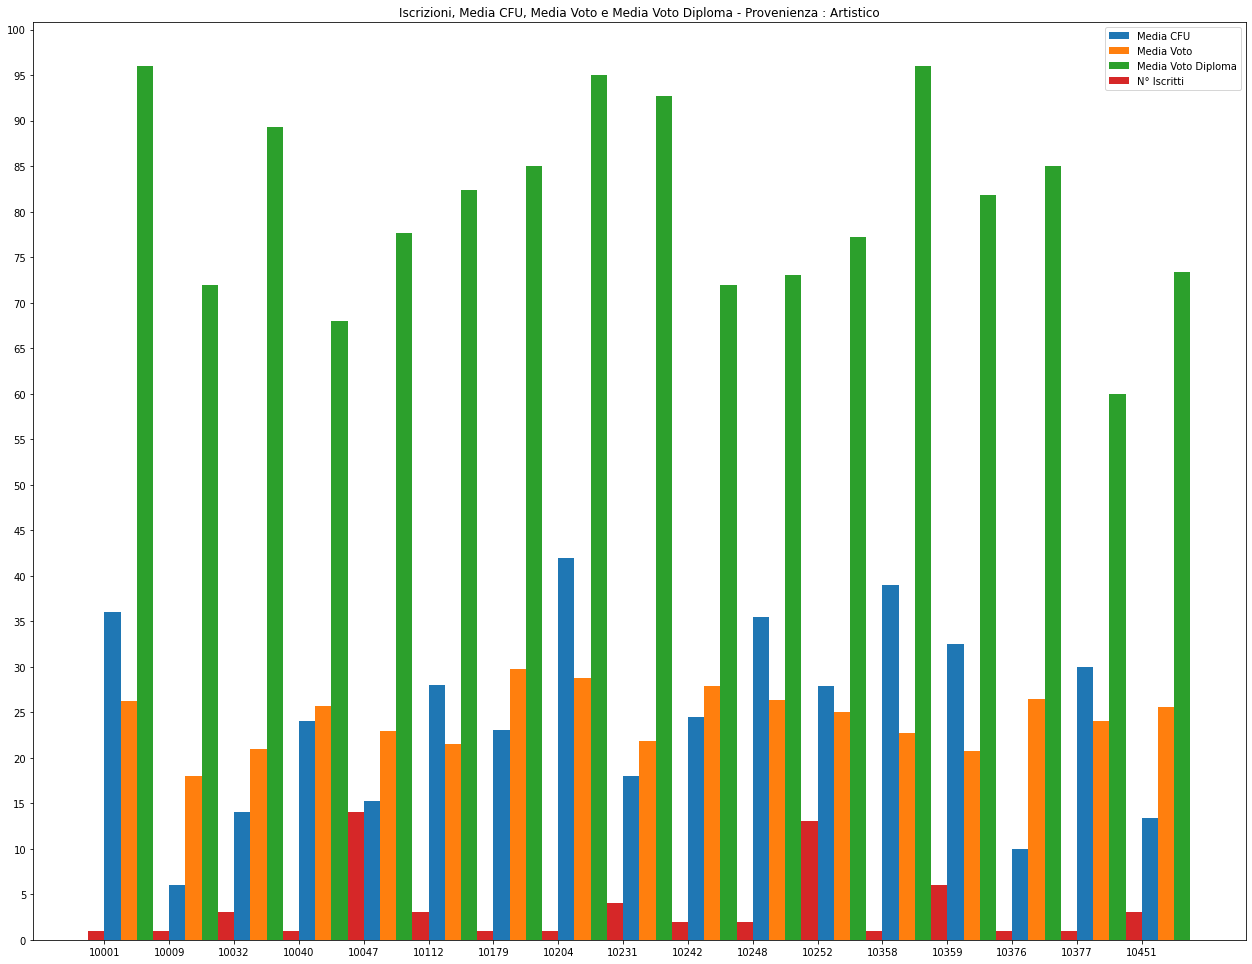

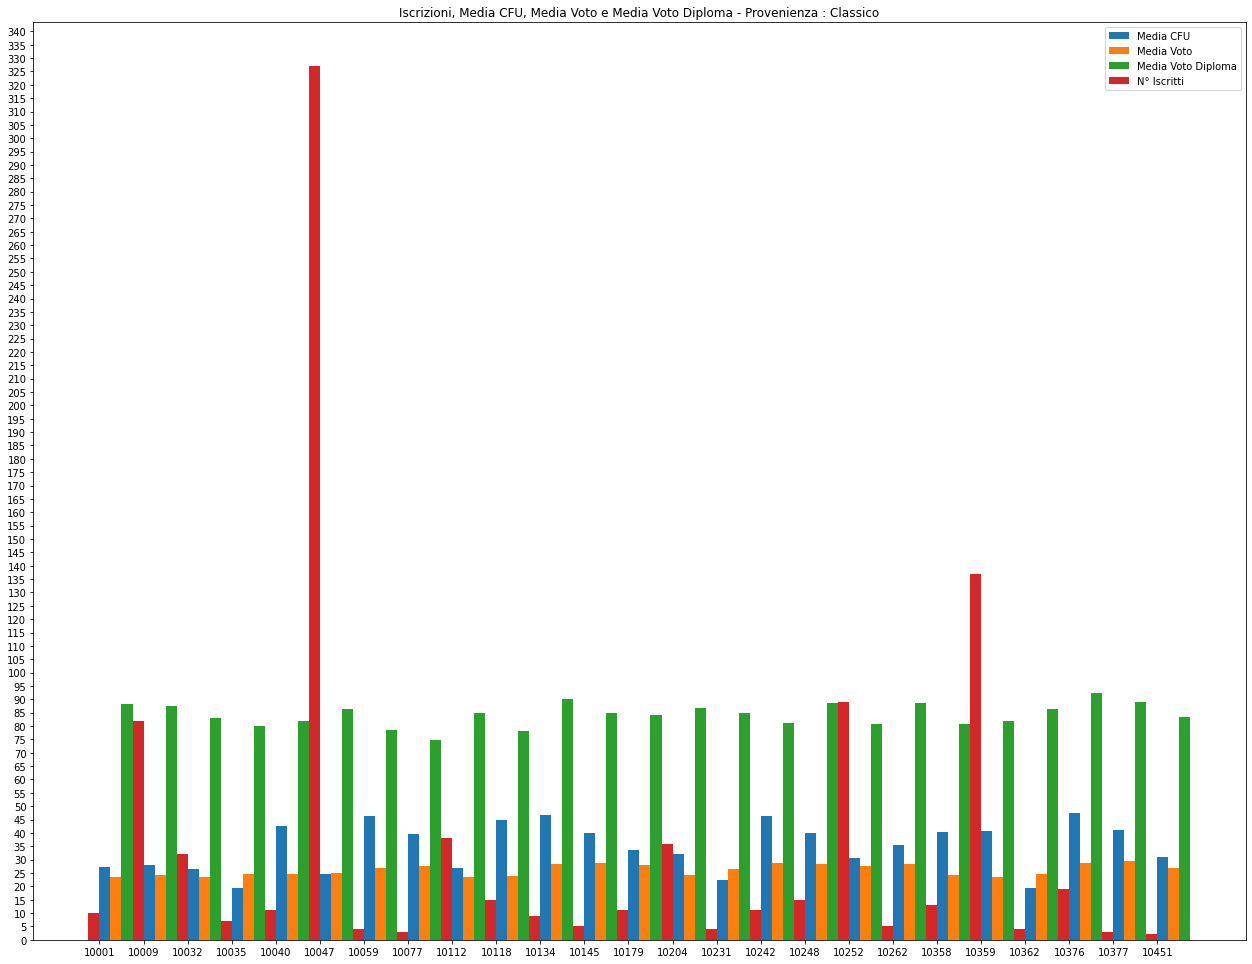

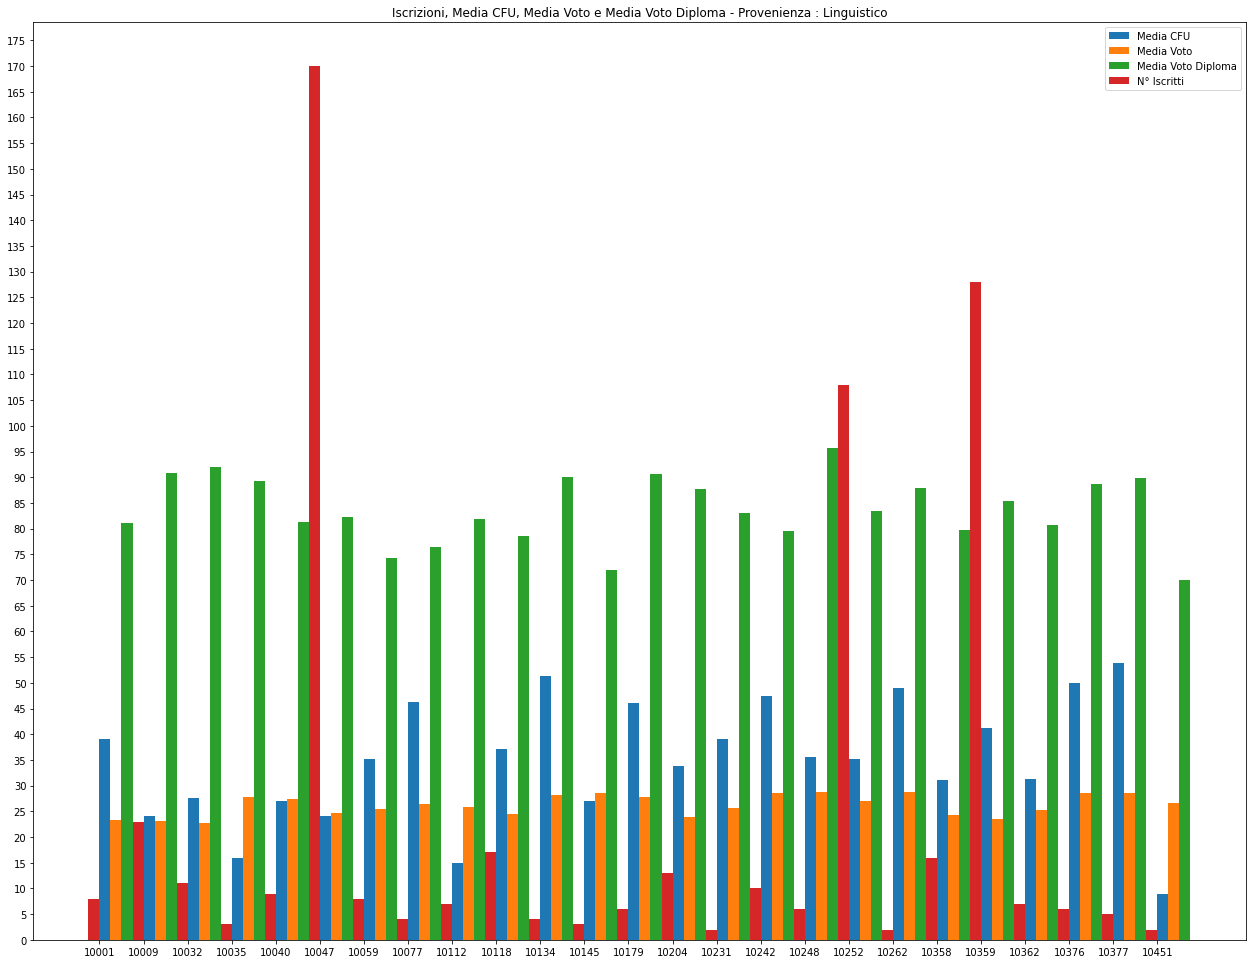

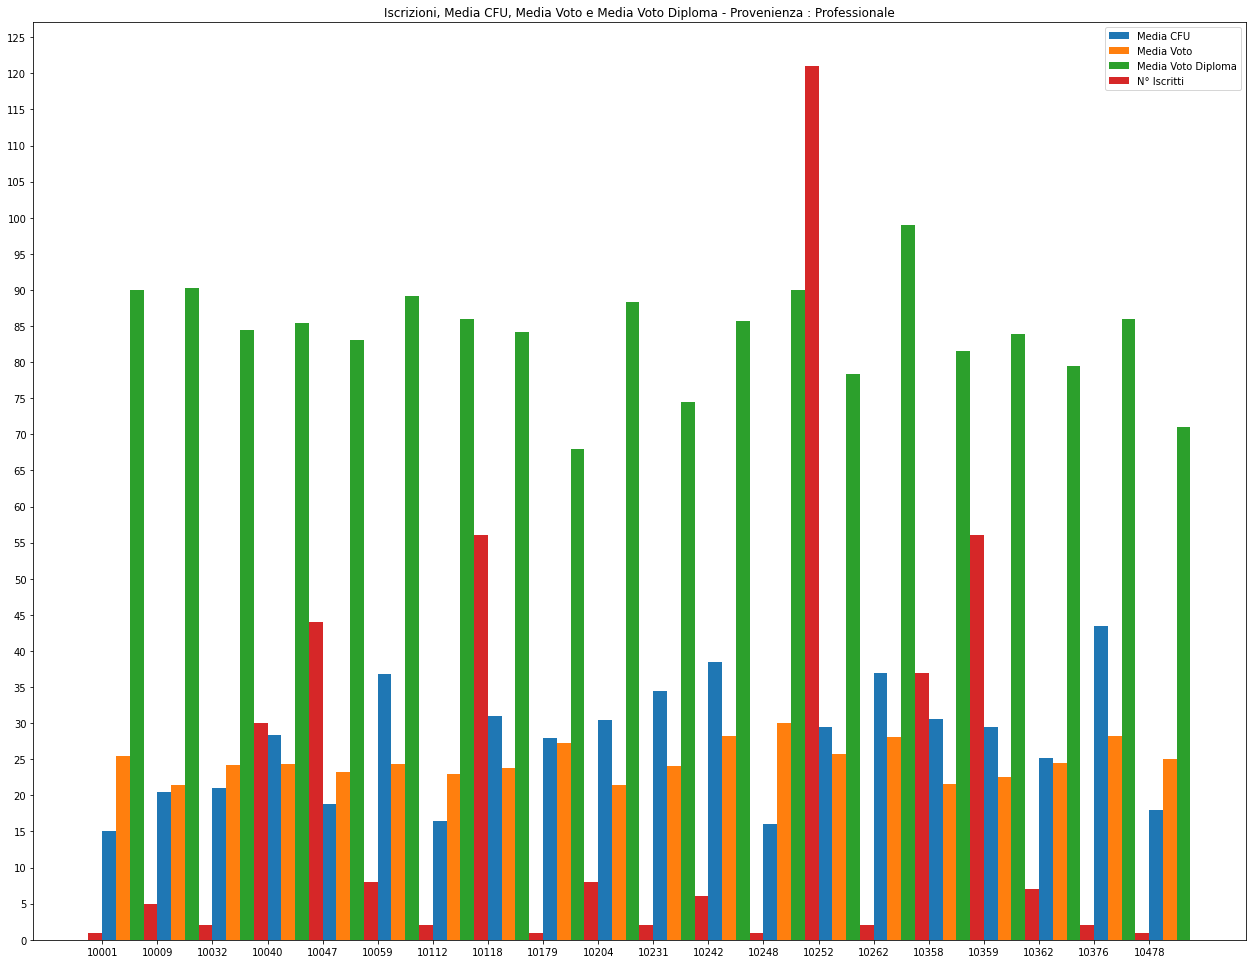

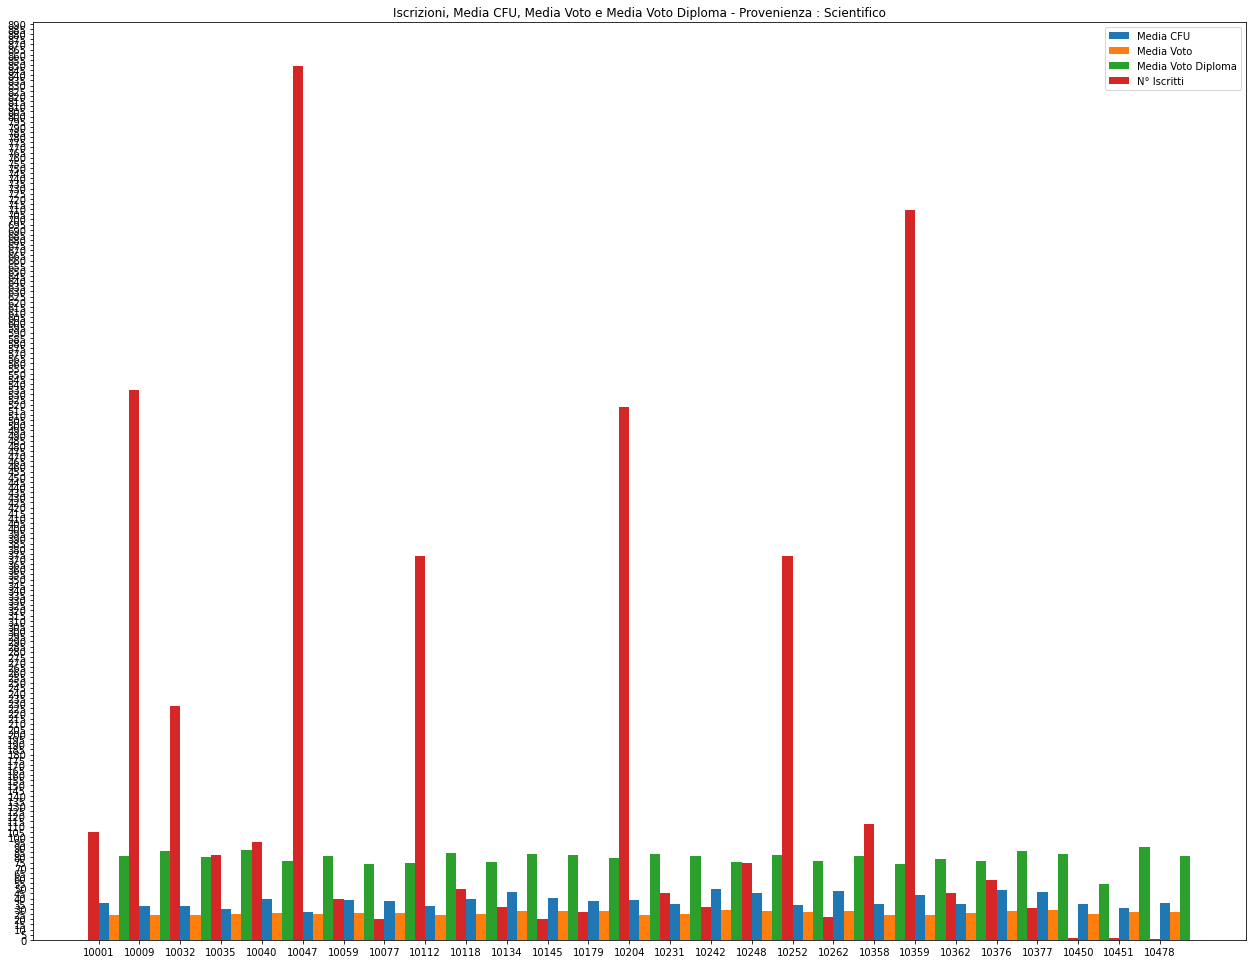

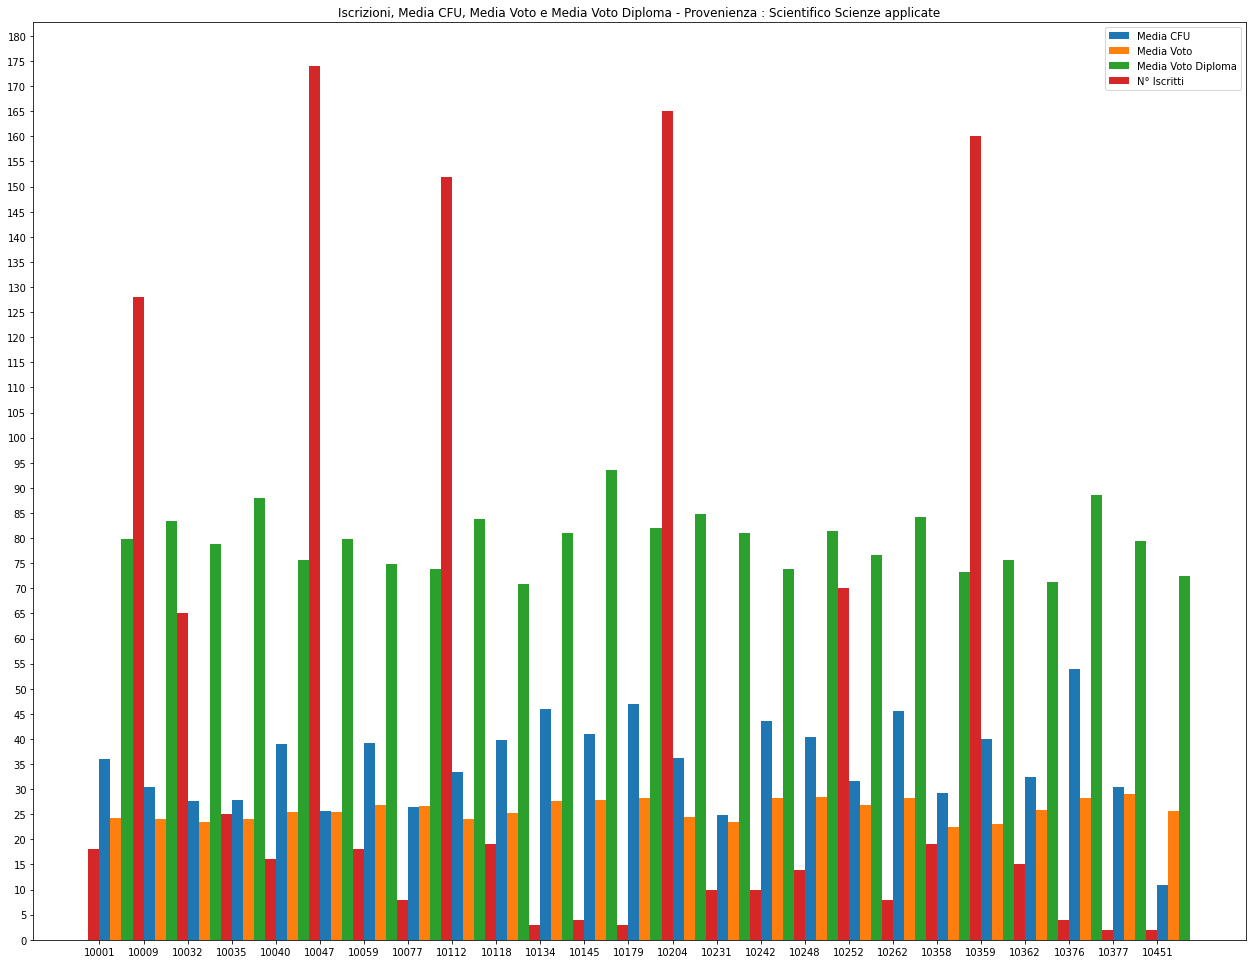

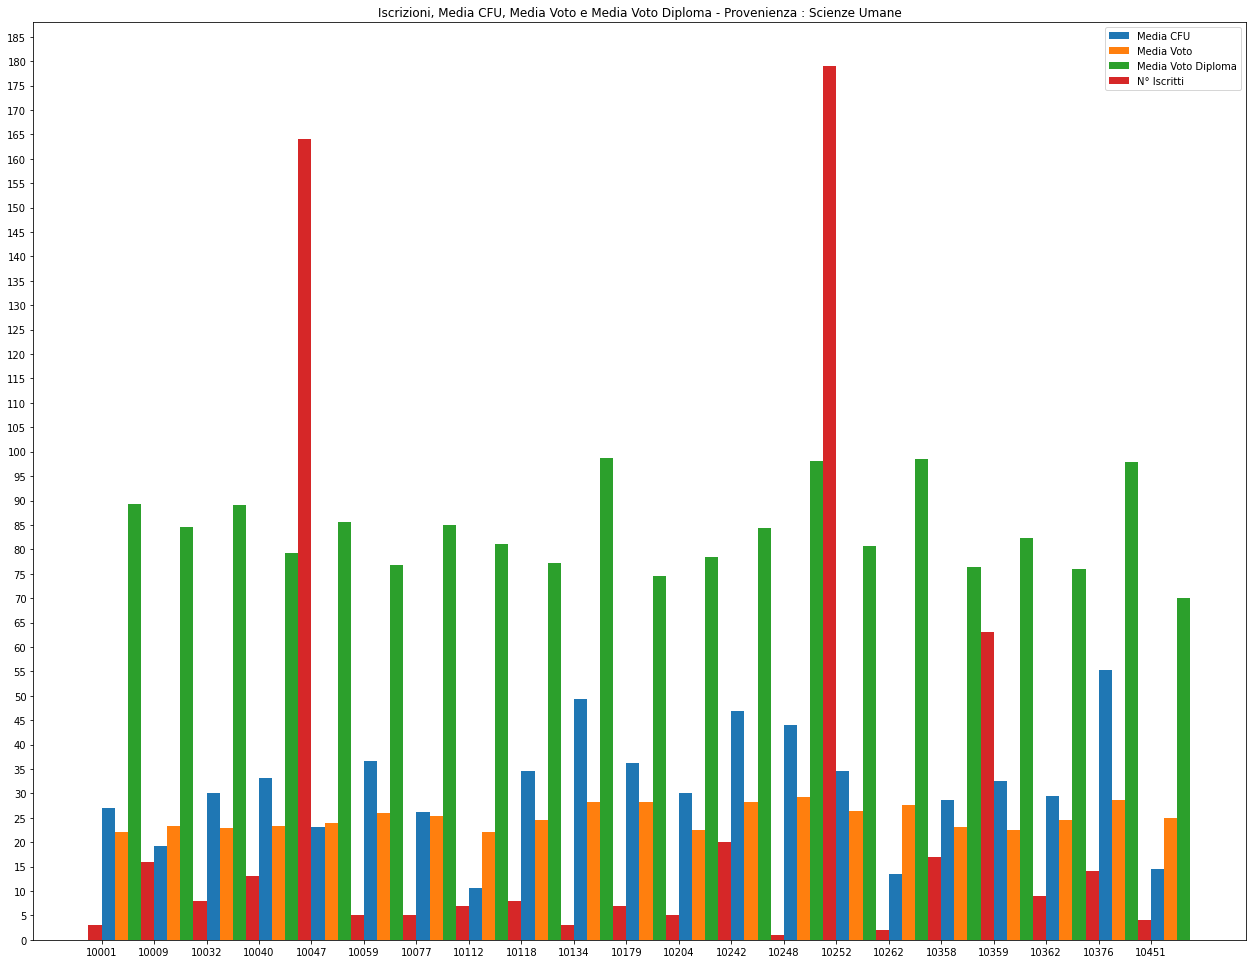

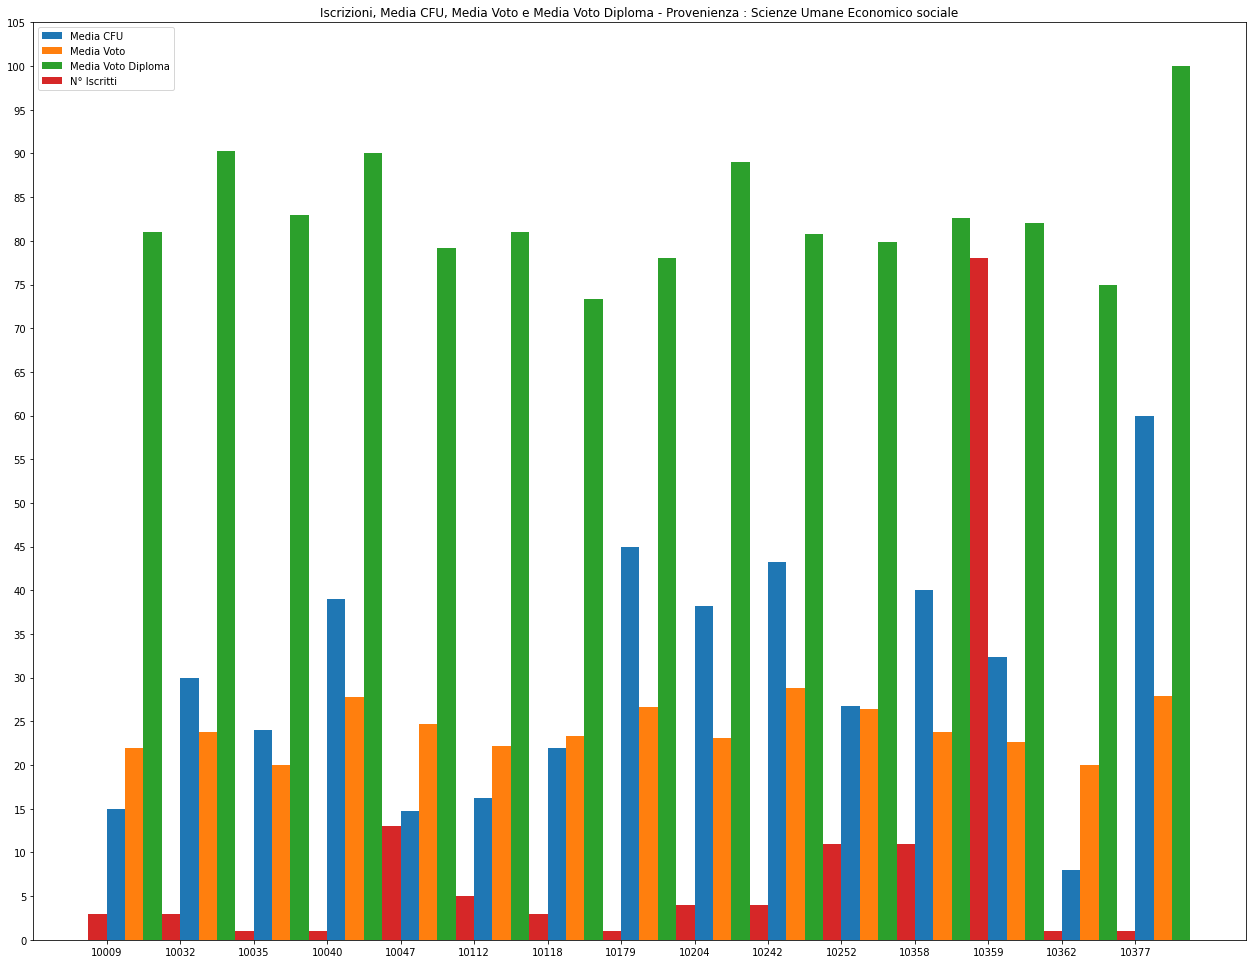

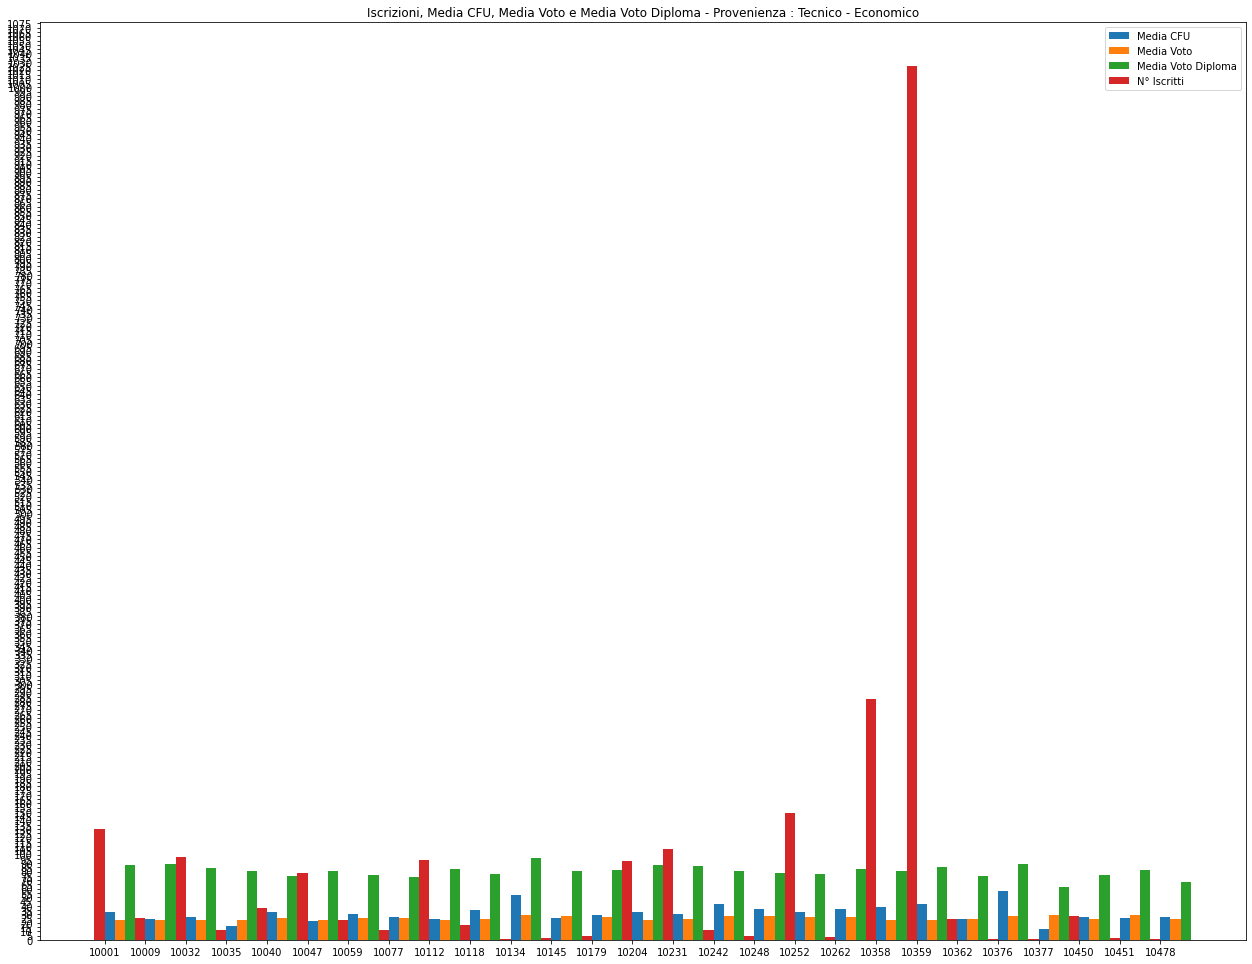

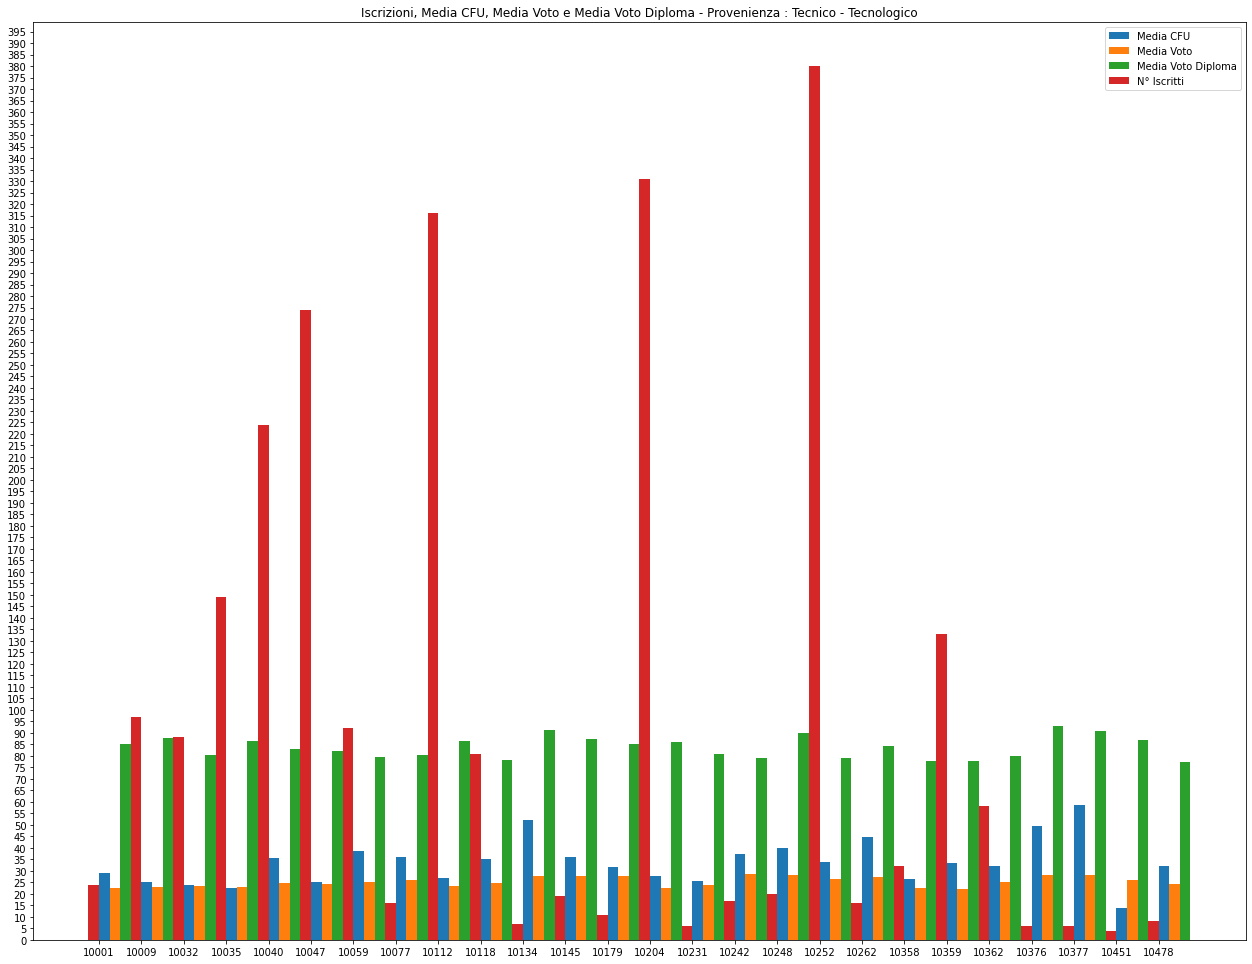

In [ ]:
Scuole_Superiori = DF_UNICO.groupby(DF_UNICO.Tipo_EDUSCOPIO)
Tipologie_di_scuole = Scuole_Superiori.groups.keys(); 


result2 = pd.DataFrame(columns=['corso', 'tipo_scuola', 'n_iscrizione', 'media_cfu', 'media_voto', 'media_voto_diploma'])
n = 0;
val_scuola_ = list()
for tipo_scuola in list(Tipologie_di_scuole):
      scuola = Scuole_Superiori.get_group(tipo_scuola)
      iscritti_CDS = scuola.groupby(scuola.CDS_ID_x)
      universita = iscritti_CDS.groups.keys(); 
      for corso in list(universita):
        somma_CFU = 0;
        
        iscritti = iscritti_CDS.get_group(corso)
        somma_CFU =  iscritti['sum(PESO_AD)'].sum();
        somma_Voto_Diploma = iscritti['VOTO'].sum();
        n_iscrizione = iscritti.MATRICOLA.nunique();
        media_cfu = round(somma_CFU/n_iscrizione,2)
        media_voto_diploma = round(somma_Voto_Diploma/n_iscrizione,2)
        media_voto = round(((iscritti['AVG(VOTO)'].sum()/n_iscrizione)),2)
        #print('corso : {} , n_studenti : {} , somma cfu : {} , media cfu : {} , somma voti : {}, media voto : {}, media_voto_diploma : {} '.format(corso, n_iscrizione, somma_CFU, media_cfu,iscritti['AVG(VOTO)'].sum(), media_voto, media_voto_diploma))
        result2 = result2.append({'corso' : str(corso), 'tipo_scuola' : tipo_scuola, 'n_iscrizione' : n_iscrizione, 'media_cfu' : media_cfu, 'media_voto': media_voto, 'media_voto_diploma' : media_voto_diploma}, ignore_index=True)


result2 = result2.groupby(by='tipo_scuola')

for tipo_g_scuola in list(Tipologie_di_scuole):
  result = result2.get_group(tipo_g_scuola)

  labels = result['corso']
  media_cfu_g = result['media_cfu']
  media_voto_g = result['media_voto']
  media_voto_diploma_g = result['media_voto_diploma']
  n_iscritti_g = result['n_iscrizione']

  x = np.arange(len(labels))  # the label locations
  width = 0.25  # the width of the bars

  fig, ax = plt.subplots()
  fig.set_size_inches(17.5, 13.5)
  plt.yticks(np.arange(0, 3000, 5))
  #rects1 = ax.bar(x - width, n_iscrizioni_g, width, label='Iscrizioni')
  rects0 = ax.bar(x , media_cfu_g, width, align='edge', label='Media CFU')
  rects1 = ax.bar(x + width, media_voto_g, width, align='edge',  label='Media Voto')
  rects2 = ax.bar(x + 2*width, media_voto_diploma_g, width, align='edge', label='Media Voto Diploma')
  rects3 = ax.bar(x - width, n_iscritti_g, width,align='edge',  label='N° Iscritti')


  ax.set_title('Iscrizioni, Media CFU, Media Voto e Media Voto Diploma - Provenienza : {}'.format(tipo_g_scuola))
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  fig.tight_layout()

  plt.show()

        


# ANALISI TEMPISTICHE CONSEGUIMENTO TITOLO E INIZIO PERCORSO UNIVERSITARIO

['PERS_ID' 'MATRICOLA' 'AA_ISCR_ID' 'CDS_ID' 'SESSO' 'AA_CONSEG_TITOLO'
 'VOTO' 'LODE' 'BASE_VOTO' 'MIUR_SCUOLE_COD' 'Tipo_EDUSCOPIO']
PRINT PRE PULIZIA : 16453 
PRINT POST PULIZIA : 16453 
Numero Errori : 2810
0 Anni : 10893 - 1 Anno : 1148 - Da 2 a 10 Anni : 1026 - Più di 10 Anni : 225


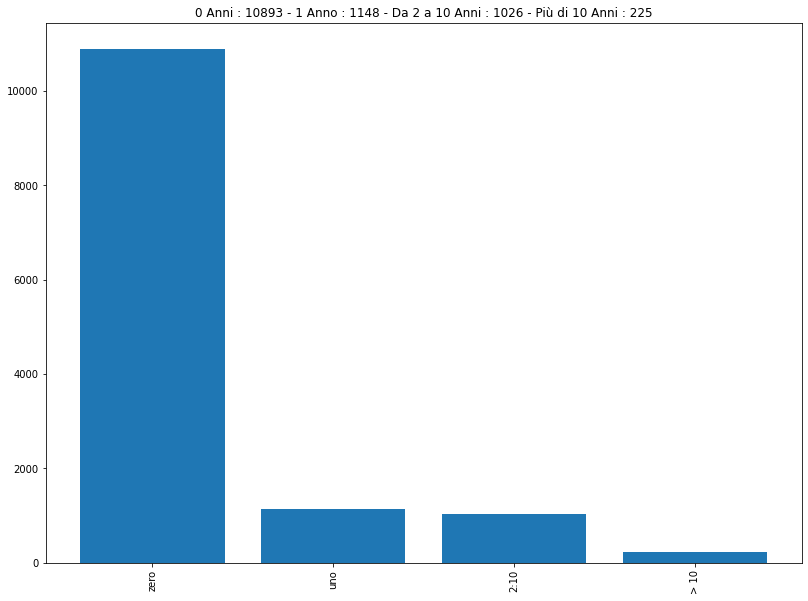

In [ ]:
DF_iscritti_analisi_tempi_stop = DF_iscritti.copy()
print(DF_iscritti_analisi_tempi_stop.columns.values)
print('PRINT PRE PULIZIA : {} '.format(len(DF_iscritti_analisi_tempi_stop)))
DF_iscritti_analisi_tempi_stop = DF_iscritti_analisi_tempi_stop.drop_duplicates(subset = ['PERS_ID','MATRICOLA'])
print('PRINT POST PULIZIA : {} '.format(len(DF_iscritti_analisi_tempi_stop)))

DF_result_tempi = pd.DataFrame(columns=['persona_id', 'anni_stop'])

errori = 0
for index, row in DF_iscritti_analisi_tempi_stop.iterrows():
  persona_id = row['PERS_ID']
  try: 
    index = DF_iscritti_analisi_tempi_stop.index[(DF_iscritti_analisi_tempi_stop['PERS_ID'] == (persona_id))][0]
    row = DF_iscritti_analisi_tempi_stop.iloc[index]
    anno_iscrizione = int(row['AA_ISCR_ID'])
    anno_conseguimento = int(row['AA_CONSEG_TITOLO'])
    diff_anni = anno_iscrizione - anno_conseguimento
    DF_result_tempi = DF_result_tempi.append({'persona_id' : persona_id , 'anni_stop' : int(diff_anni)}, ignore_index=True)
    
  except:
    errori = errori + 1

print('Numero Errori : {}'.format(errori))

DF_result_tempi_g = DF_result_tempi.groupby(by='persona_id')
persone = DF_result_tempi_g.groups.keys();

due_dieci = 0
piu_di_dieci = 0
zero = 0
uno = 0

for persona in list(persone):
  DF_result_tempi_g_persona = DF_result_tempi_g.get_group(persona)
  n_anni = DF_result_tempi_g_persona['anni_stop'].values[0]
  
  if n_anni == 0:
    zero = zero + 1
  elif n_anni == 1: 
    uno = uno + 1
  elif n_anni > 1 and n_anni <=10:
    due_dieci = due_dieci + 1 
  elif n_anni > 10: 
    piu_di_dieci = piu_di_dieci + 1 


print('0 Anni : {} - 1 Anno : {} - Da 2 a 10 Anni : {} - Più di 10 Anni : {}'.format(zero, uno, due_dieci, piu_di_dieci))

fig = plt.figure()
ax = fig.add_axes([0,0,1,1]) 
x_campo = ['zero', 'uno' , '2:10' , '> 10']
y_campo = [zero, uno, due_dieci, piu_di_dieci]
fig.set_size_inches(10.5, 7.5)
ax.bar(x_campo,y_campo)
plt.xticks(rotation=90)
plt.title('0 Anni : {} - 1 Anno : {} - Da 2 a 10 Anni : {} - Più di 10 Anni : {}'.format(zero, uno, due_dieci, piu_di_dieci))
plt.show()

# MODELLO PREDITTIVO

### Dati 

In [ ]:
Scuole_Superiori = DF_UNICO.groupby(DF_UNICO.Tipo_EDUSCOPIO)
Tipologie_di_scuole = Scuole_Superiori.groups.keys(); 

print(Scuole_Superiori)

result_studenti_scuole = pd.DataFrame(columns=['matricola','scuola','cfu', 'voto', 'maturita'])
n = 0;
for index, row in DF_UNICO.iterrows():
      result_studenti_scuole = result_studenti_scuole.append({'matricola' : row['MATRICOLA'],
                                                             'scuola' : row['Tipo_EDUSCOPIO'],
                                                             'cfu' : row['sum(PESO_AD)'],
                                                             'voto' : row['AVG(VOTO)'],
                                                             'maturita' : row['VOTO']}, ignore_index = True)
      
result_studenti_scuole.to_csv('result_unico.csv')

result_studenti_scuole['scuola'] = result_studenti_scuole['scuola'].map(
    {
     'Artistico' : int(0), 
     'Classico': int(1),
     'Linguistico': int(2),
     'Professionale': int(3),
     'Scientifico' : int(4), 
     'Scientifico Scienze applicate' : int(5),
     'Scienze Umane': int(6),
     'Scienze Umane Economico sociale' : int(7),
     'Tecnico - Economico' : int(8),
     'Tecnico - Tecnologico' : int(9)
    }
)

condizioni  = [ result_studenti_scuole['voto']<21 , 
               (result_studenti_scuole['voto'] >= 21 ) & (result_studenti_scuole['voto'] < 22),
               (result_studenti_scuole['voto'] >= 22 ) & (result_studenti_scuole['voto'] < 23),
               (result_studenti_scuole['voto'] >= 23 ) & (result_studenti_scuole['voto'] < 24),
               (result_studenti_scuole['voto'] >= 24 ) & (result_studenti_scuole['voto'] < 25),
               (result_studenti_scuole['voto'] >= 25 ) & (result_studenti_scuole['voto'] < 26),
               (result_studenti_scuole['voto'] >= 26 ) & (result_studenti_scuole['voto'] < 27),
               (result_studenti_scuole['voto'] >= 27 ) & (result_studenti_scuole['voto'] < 28),
               (result_studenti_scuole['voto'] >= 28 ) & (result_studenti_scuole['voto'] < 29),
               result_studenti_scuole['voto']>= 29
               ]


condizioni_cfu  = [ result_studenti_scuole['cfu']<10 , 
               (result_studenti_scuole['cfu'] >= 10 ) & (result_studenti_scuole['cfu'] < 20),
               (result_studenti_scuole['cfu'] >= 20 ) & (result_studenti_scuole['cfu'] < 30),
               (result_studenti_scuole['cfu'] >= 30 ) & (result_studenti_scuole['cfu'] < 40),
               (result_studenti_scuole['cfu'] >= 40 ) & (result_studenti_scuole['cfu'] < 50),
               (result_studenti_scuole['cfu'] >= 50 ) & (result_studenti_scuole['cfu'] < 60),
               result_studenti_scuole['cfu']>= 60
               ]

scelte_cfu     = [0,10,20,30,40,50,60]

scelte     = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    
result_studenti_scuole['voto'] = np.select(condizioni, scelte, default=np.nan)

result_studenti_scuole['cfu'] = np.select(condizioni_cfu, scelte_cfu, default=np.nan)


result_studenti_scuole.to_csv('modello predittivo.csv')

result_studenti_scuole.head()

,matricola,scuola,cfu,voto,maturita
0,00027EDDD55C51F668558C1BBC93852D,4,10.0,1.0,74.0
1,0004D7F73A2E5D764603CD68DCDEC115,5,10.0,8.0,61.0
2,0010B15A6FE7B318A144E2B5C8A87CC5,4,20.0,3.0,67.0
3,00122E576F0F42D3C800EB8F9BB6D35F,4,60.0,3.0,62.0
4,00152A8901E4C527DF527DBFFAF73B42,1,50.0,8.0,63.0


### Regressione Lineare e Logistica

RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
Linear Regression : LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
REG COEF : [-0.0775909] 
reg.intercept : 29.33230237493289 


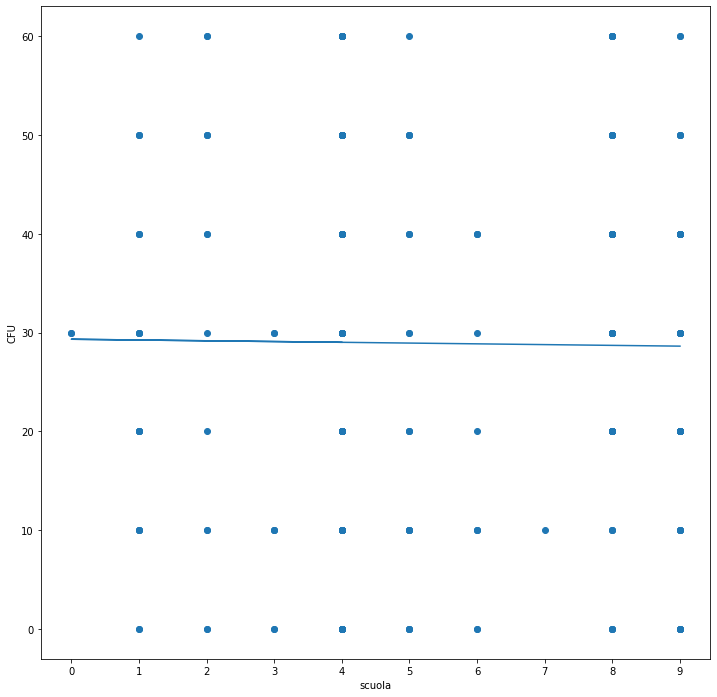

In [ ]:
reg = linear_model.LinearRegression()
X = result_studenti_scuole[['scuola']].values
y = result_studenti_scuole[['cfu']].values 
y = np.ravel(y)

### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]


reg.fit(X_train, y_train)
print('Linear Regression : {}'.format(reg))
print('REG COEF : {} '.format(reg.coef_))
print('reg.intercept : {} '.format(reg.intercept_))


# predict y from the data
x_new = X_test
y_new = reg.predict(X_test.reshape(-1,1))

# plot the results
plt.figure(figsize=(12, 12))
ax = plt.axes()
ax.scatter(X_test, y_test)
ax.plot(x_new, y_new)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_yticks([x for x in [0,10,20,30,40,50,60]])
#ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
#ax.set_ylabel('voto')
ax.set_ylabel('CFU')
ax.set_xlabel('scuola')

ax.axis('tight')


plt.show()


RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
Linear Regression : LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
REG COEF : [-0.13649827] 
reg.intercept : 6.070936743342933 


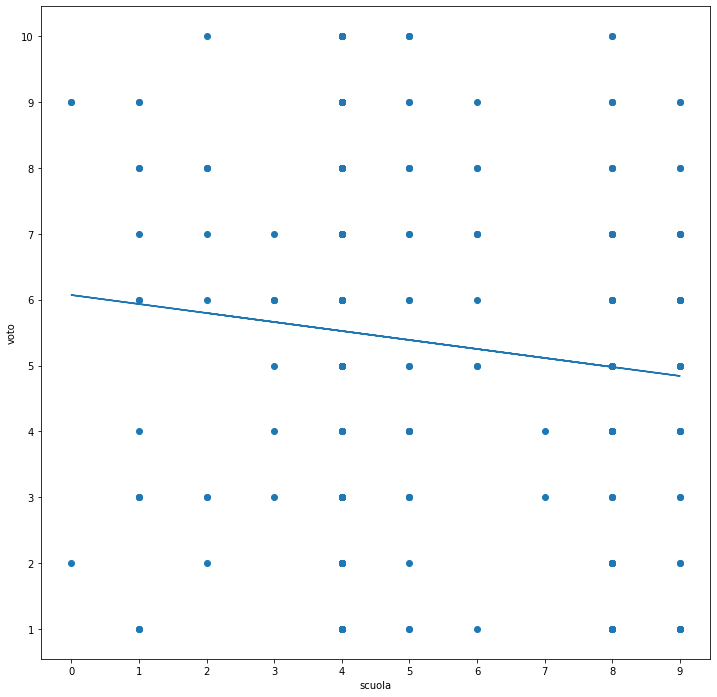

In [ ]:
reg = linear_model.LinearRegression()
X = result_studenti_scuole[['scuola']].values
y = result_studenti_scuole[['voto']].values 
y = np.ravel(y)

### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]


reg.fit(X_train, y_train)
print('Linear Regression : {}'.format(reg))
print('REG COEF : {} '.format(reg.coef_))
print('reg.intercept : {} '.format(reg.intercept_))


# predict y from the data
x_new = X_test
y_new = reg.predict(X_test.reshape(-1,1))

# plot the results
plt.figure(figsize=(12, 12))
ax = plt.axes()
ax.scatter(X_test, y_test)
ax.plot(x_new, y_new)
ax.set_yticks([1,2,3,4,5,6,7,8,9,10])
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
#ax.set_ylabel('voto')
ax.set_ylabel('voto')
ax.set_xlabel('scuola')

ax.axis('tight')


plt.show()


RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
Linear Regression : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
REG COEF : [[ 0.00111782]
 [ 0.00473419]
 [-0.00836506]
 [ 0.02326251]
 [-0.00847818]
 [-0.05145447]
 [ 0.03918319]] 
reg.intercept : [-0.06279    -0.06832863  0.13203161  0.21720967  0.20590424  0.34134643
 -0.76537332] 


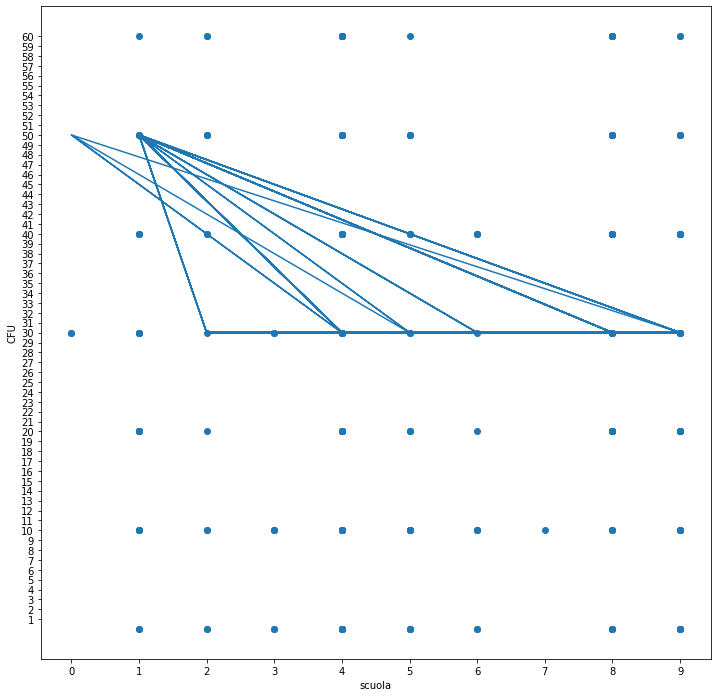

In [ ]:
reg = linear_model.LogisticRegression()

#X = result_studenti_scuole[['voto', 'cfu']].values 
X = result_studenti_scuole[['scuola']].values 
#print(X) 
y = result_studenti_scuole[['cfu']].values
y = np.ravel(y)
#print(y)

### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]



reg.fit(X_train, y_train)
print('Linear Regression : {}'.format(reg))
print('REG COEF : {} '.format(reg.coef_))
print('reg.intercept : {} '.format(reg.intercept_))




# predict y from the data
x_new = X_test
y_new = reg.predict(X_test.reshape(-1,1))

# plot the results
plt.figure(figsize=(12, 12))
ax = plt.axes()
ax.scatter(X_test, y_test)
ax.plot(x_new, y_new)
#ax.set_yticks([1,2,3,4,5,6,7,8,9,10])
ax.set_yticks([x+1 for x in range(60)])
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
#ax.set_ylabel('voto')
ax.set_ylabel('CFU')
ax.set_xlabel('scuola')


plt.show()

RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
Linear Regression : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
REG COEF : [[ 0.07819292]
 [ 0.04614964]
 [ 0.04388356]
 [ 0.0453244 ]
 [ 0.02286581]
 [-0.00217818]
 [-0.02020695]
 [-0.0160897 ]
 [-0.07546652]
 [-0.12247499]] 
reg.intercept : [-0.23659834 -0.46785011 -0.31282164 -0.17065743  0.08814675  0.21149976
  0.23935857  0.1314639   0.31738806  0.20007049] 


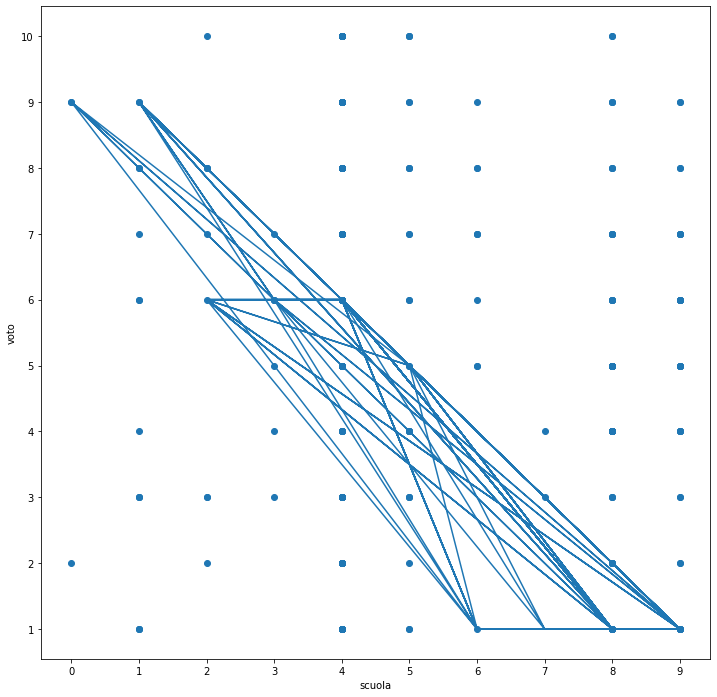

In [ ]:
reg = linear_model.LogisticRegression()

#X = result_studenti_scuole[['voto', 'cfu']].values 
X = result_studenti_scuole[['scuola']].values 
#print(X) 
y = result_studenti_scuole[['voto']].values
y = np.ravel(y)
#print(y)

### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]



reg.fit(X_train, y_train)
print('Linear Regression : {}'.format(reg))
print('REG COEF : {} '.format(reg.coef_))
print('reg.intercept : {} '.format(reg.intercept_))

# predict y from the data
x_new = X_test
y_new = reg.predict(X_test.reshape(-1,1))

# plot the results
plt.figure(figsize=(12, 12))
ax = plt.axes()
ax.scatter(X_test, y_test)
ax.plot(x_new, y_new)
ax.set_yticks([1,2,3,4,5,6,7,8,9,10])
ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_ylabel('voto')
ax.set_xlabel('scuola')


plt.show()

### KNN (VOTO + CFU)

RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
[[14  1  3  1  1  0  3  7  0  0]
 [ 9  0  1  2  3  0  2  1  2  0]
 [11  0  0  2  2  2  1  5  0  0]
 [10  0  2  3  1  5  1  2  3  1]
 [10  0  2  1  4  4  2  4  4  0]
 [ 6  0  1  2  9  3  4  3  3  0]
 [ 6  0  3  1  0  9  2  3  3  1]
 [ 7  0  0  3  1  2  2  2  3  7]
 [ 5  1  0  1  0  3  1  2  4  6]
 [ 1  0  0  0  3  3  2  1  1  5]]
              precision    recall  f1-score   support

         1.0       0.18      0.47      0.26        30
         2.0       0.00      0.00      0.00        20
         3.0       0.00      0.00      0.00        23
         4.0       0.19      0.11      0.14        28
         5.0       0.17      0.13      0.15        31
         6.0       0.10      0.10      0.10        31
         7.0       0.10      0.07      0.08        28
         8.0       0.07      0.07      0.07        27
         9.0       0.17      0.17      0.17        23
        10.0       0.25      0.31      0.28        16

    a

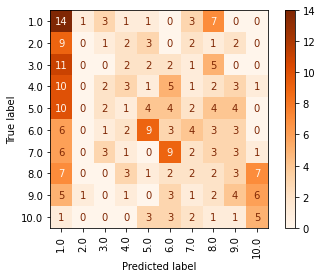

In [ ]:
#y = result_studenti_scuole[['voto', 'cfu']].values 
y = result_studenti_scuole[['voto']].values 
#print(X) 
X = result_studenti_scuole[['scuola','maturita']].values #'voto'
y = np.ravel(y)
#print(y)

class_names = [
      'Artistico', 
     'Classico',
     'Linguistico',
     'Professionale',
     'Scientifico', 
     'Scientifico Scienze applicate',
     'Scienze Umane',
     'Scienze Umane Economico sociale',
     'Tecnico - Economico',
     'Tecnico - Tecnologico',
     'y_true'
]


### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]


scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


classifier = KNeighborsClassifier(n_neighbors=80)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(classifier, X_test, y_test, xticks_rotation=90, cmap='Oranges')  


RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
[[ 5  5  5 12  2  5  0]
 [10  4  0 11  3  6  0]
 [ 4  9  8  7  7  1  3]
 [ 6  6  6 17  3 12  0]
 [ 3  2  4 14  7 11  1]
 [ 2  3  8  6  7  9  3]
 [ 0  2  2  4  4  4  4]]
              precision    recall  f1-score   support

         0.0       0.17      0.15      0.16        34
        10.0       0.13      0.12      0.12        34
        20.0       0.24      0.21      0.22        39
        30.0       0.24      0.34      0.28        50
        40.0       0.21      0.17      0.19        42
        50.0       0.19      0.24      0.21        38
        60.0       0.36      0.20      0.26        20

    accuracy                           0.21       257
   macro avg       0.22      0.20      0.21       257
weighted avg       0.21      0.21      0.21       257



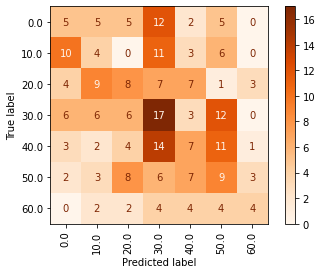

In [ ]:
#y = result_studenti_scuole[['voto', 'cfu']].values 
y = result_studenti_scuole[['cfu']].values 
#print(X) 
X = result_studenti_scuole[['scuola','maturita']].values #'voto'
y = np.ravel(y)
#print(y)

class_names = [
      'Artistico', 
     'Classico',
     'Linguistico',
     'Professionale',
     'Scientifico', 
     'Scientifico Scienze applicate',
     'Scienze Umane',
     'Scienze Umane Economico sociale',
     'Tecnico - Economico',
     'Tecnico - Tecnologico',
     'y_true'
]


### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]


scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


classifier = KNeighborsClassifier(n_neighbors=80)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test, y_pred))

plot_confusion_matrix(classifier, X_test, y_test, xticks_rotation=90, cmap='Oranges')  


### SVM (VOTO + CFU)

RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
[[ 0  0  1 31  0  2  0]
 [ 0  0  0 27  0  7  0]
 [ 0  0  1 35  0  3  0]
 [ 0  0  1 39  0 10  0]
 [ 0  0  1 30  0 11  0]
 [ 0  0  0 29  0  9  0]
 [ 0  0  0 15  0  5  0]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        34
        10.0       0.00      0.00      0.00        34
        20.0       0.25      0.03      0.05        39
        30.0       0.19      0.78      0.30        50
        40.0       0.00      0.00      0.00        42
        50.0       0.19      0.24      0.21        38
        60.0       0.00      0.00      0.00        20

    accuracy                           0.19       257
   macro avg       0.09      0.15      0.08       257
weighted avg       0.10      0.19      0.10       257



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


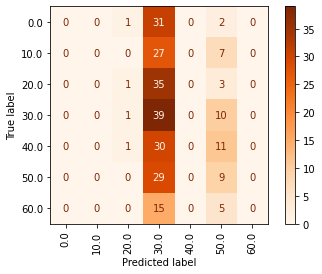

In [ ]:
#y = result_studenti_scuole[['voto', 'cfu']].values 
y = result_studenti_scuole[['cfu']].values 
#print(X) 
X = result_studenti_scuole[['scuola','maturita']].values
y = np.ravel(y)
#print(y)

### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

clf = svm.SVC(kernel='poly', degree=3, C = 1.0, decision_function_shape='ovo') 

clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


plot_confusion_matrix(clf, X_test, y_test, xticks_rotation=90, cmap='Oranges')  


RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
[[21  0  0  0  3  1  0  3  2  0]
 [16  0  0  0  0  0  0  2  2  0]
 [14  0  0  0  4  3  0  1  1  0]
 [17  0  0  0  1  0  0  7  3  0]
 [19  0  0  0  3  0  0  8  1  0]
 [13  0  0  0  4  4  0  7  3  0]
 [15  0  0  0  2  2  0  7  2  0]
 [10  0  0  0  4  0  0  2 11  0]
 [ 5  0  0  0  2  1  0  5 10  0]
 [ 2  0  0  0  4  1  0  2  7  0]]
              precision    recall  f1-score   support

         1.0       0.16      0.70      0.26        30
         2.0       0.00      0.00      0.00        20
         3.0       0.00      0.00      0.00        23
         4.0       0.00      0.00      0.00        28
         5.0       0.11      0.10      0.10        31
         6.0       0.33      0.13      0.19        31
         7.0       0.00      0.00      0.00        28
         8.0       0.05      0.07      0.06        27
         9.0       0.24      0.43      0.31        23
        10.0       0.00      0.00      0.00        16

    a

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


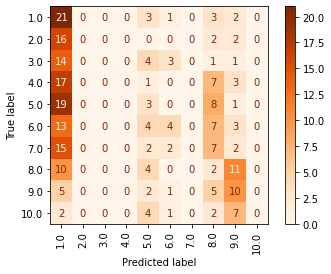

In [ ]:
#y = result_studenti_scuole[['voto', 'cfu']].values 
y = result_studenti_scuole[['voto']].values 
#print(X) 
X = result_studenti_scuole[['scuola','maturita']].values
y = np.ravel(y)
#print(y)

### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]

clf = svm.SVC(kernel='poly', degree=3, C = 1.0, decision_function_shape='ovo') 

clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


plot_confusion_matrix(clf, X_test, y_test, xticks_rotation=90, cmap='Oranges')  


### TREE

RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
[[15  1  2  2  5  0  2  2  1  0]
 [ 9  1  1  2  6  0  1  0  0  0]
 [10  2  0  2  4  1  1  3  0  0]
 [ 9  1  1  5  2  1  4  1  3  1]
 [ 9  0  2  3  4  1  4  4  4  0]
 [ 8  0  1  2  7  3  4  4  2  0]
 [ 8  1  1  5  2  1  4  3  2  1]
 [ 7  0  0  1  1  1  2  4  4  7]
 [ 4  1  0  0  2  0  4  3  3  6]
 [ 1  0  0  0  2  1  2  4  1  5]]
              precision    recall  f1-score   support

         1.0       0.19      0.50      0.27        30
         2.0       0.14      0.05      0.07        20
         3.0       0.00      0.00      0.00        23
         4.0       0.23      0.18      0.20        28
         5.0       0.11      0.13      0.12        31
         6.0       0.33      0.10      0.15        31
         7.0       0.14      0.14      0.14        28
         8.0       0.14      0.15      0.15        27
         9.0       0.15      0.13      0.14        23
        10.0       0.25      0.31      0.28        16

    a

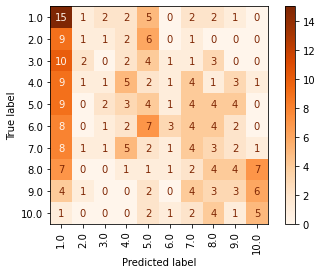

In [ ]:
#y = result_studenti_scuole[['voto', 'cfu']].values 
y = result_studenti_scuole[['voto']].values 
#print(X) 
X = result_studenti_scuole[['scuola','maturita']].values
y = np.ravel(y)
#print(y)

### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]


clf = tree.DecisionTreeClassifier(criterion='gini', 
                                  splitter='best', 
                                  max_depth=10, min_samples_split=2, 
                                  min_samples_leaf=4, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_features=1, 
                                  random_state=42, 
                                  max_leaf_nodes=None, 
                                  class_weight=None, ccp_alpha=0.0)



clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


plot_confusion_matrix(clf, X_test, y_test, xticks_rotation=90, cmap='Oranges') 

RepeatedStratifiedKFold(n_repeats=10, n_splits=50, random_state=42)
[[ 3  3  4 13  7  4  0]
 [ 8  3  3 16  1  2  1]
 [ 4  9  3 11  9  1  2]
 [ 8  3  5 15 10  9  0]
 [ 4  4  1 15  8 10  0]
 [ 0  4  1 14  6 10  3]
 [ 0  2  0  4  6  3  5]]
              precision    recall  f1-score   support

         0.0       0.11      0.09      0.10        34
        10.0       0.11      0.09      0.10        34
        20.0       0.18      0.08      0.11        39
        30.0       0.17      0.30      0.22        50
        40.0       0.17      0.19      0.18        42
        50.0       0.26      0.26      0.26        38
        60.0       0.45      0.25      0.32        20

    accuracy                           0.18       257
   macro avg       0.21      0.18      0.18       257
weighted avg       0.19      0.18      0.18       257



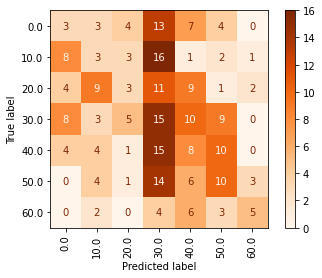

In [ ]:
#y = result_studenti_scuole[['voto', 'cfu']].values 
y = result_studenti_scuole[['cfu']].values 
#print(X) 
X = result_studenti_scuole[['scuola','maturita']].values
y = np.ravel(y)
#print(y)

### -------SPLIT SEMPLICE ------###
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True, stratify=y)

### -------SPLIT StratifiedShuffleSplit ------###
#sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
#sss.get_n_splits(X, y)
#print(sss)
#StratifiedShuffleSplit(n_splits=5, random_state=0)
#for train_index, test_index in sss.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

### -------SPLIT StratifiedKFold ------###
#skf = StratifiedKFold(n_splits=50, random_state=42, shuffle=True)
#skf.get_n_splits(X, y)
#print(skf)
#for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]


### -------SPLIT RepeatedStratifiedKFold ------###
skf = RepeatedStratifiedKFold(n_splits=50, random_state=42, n_repeats=10)
skf.get_n_splits(X, y)
print(skf)
for train_index, test_index in skf.split(X, y):
     #print("TRAIN:", train_index, "TEST:", test_index)
     X_train, X_test = X[train_index], X[test_index]
     y_train, y_test = y[train_index], y[test_index]


clf = tree.DecisionTreeClassifier(criterion='gini', 
                                  splitter='best', 
                                  max_depth=10, min_samples_split=2, 
                                  min_samples_leaf=4, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_features=1, 
                                  random_state=42, 
                                  max_leaf_nodes=None, 
                                  class_weight=None, ccp_alpha=0.0)



clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


plot_confusion_matrix(clf, X_test, y_test, xticks_rotation=90, cmap='Oranges') 

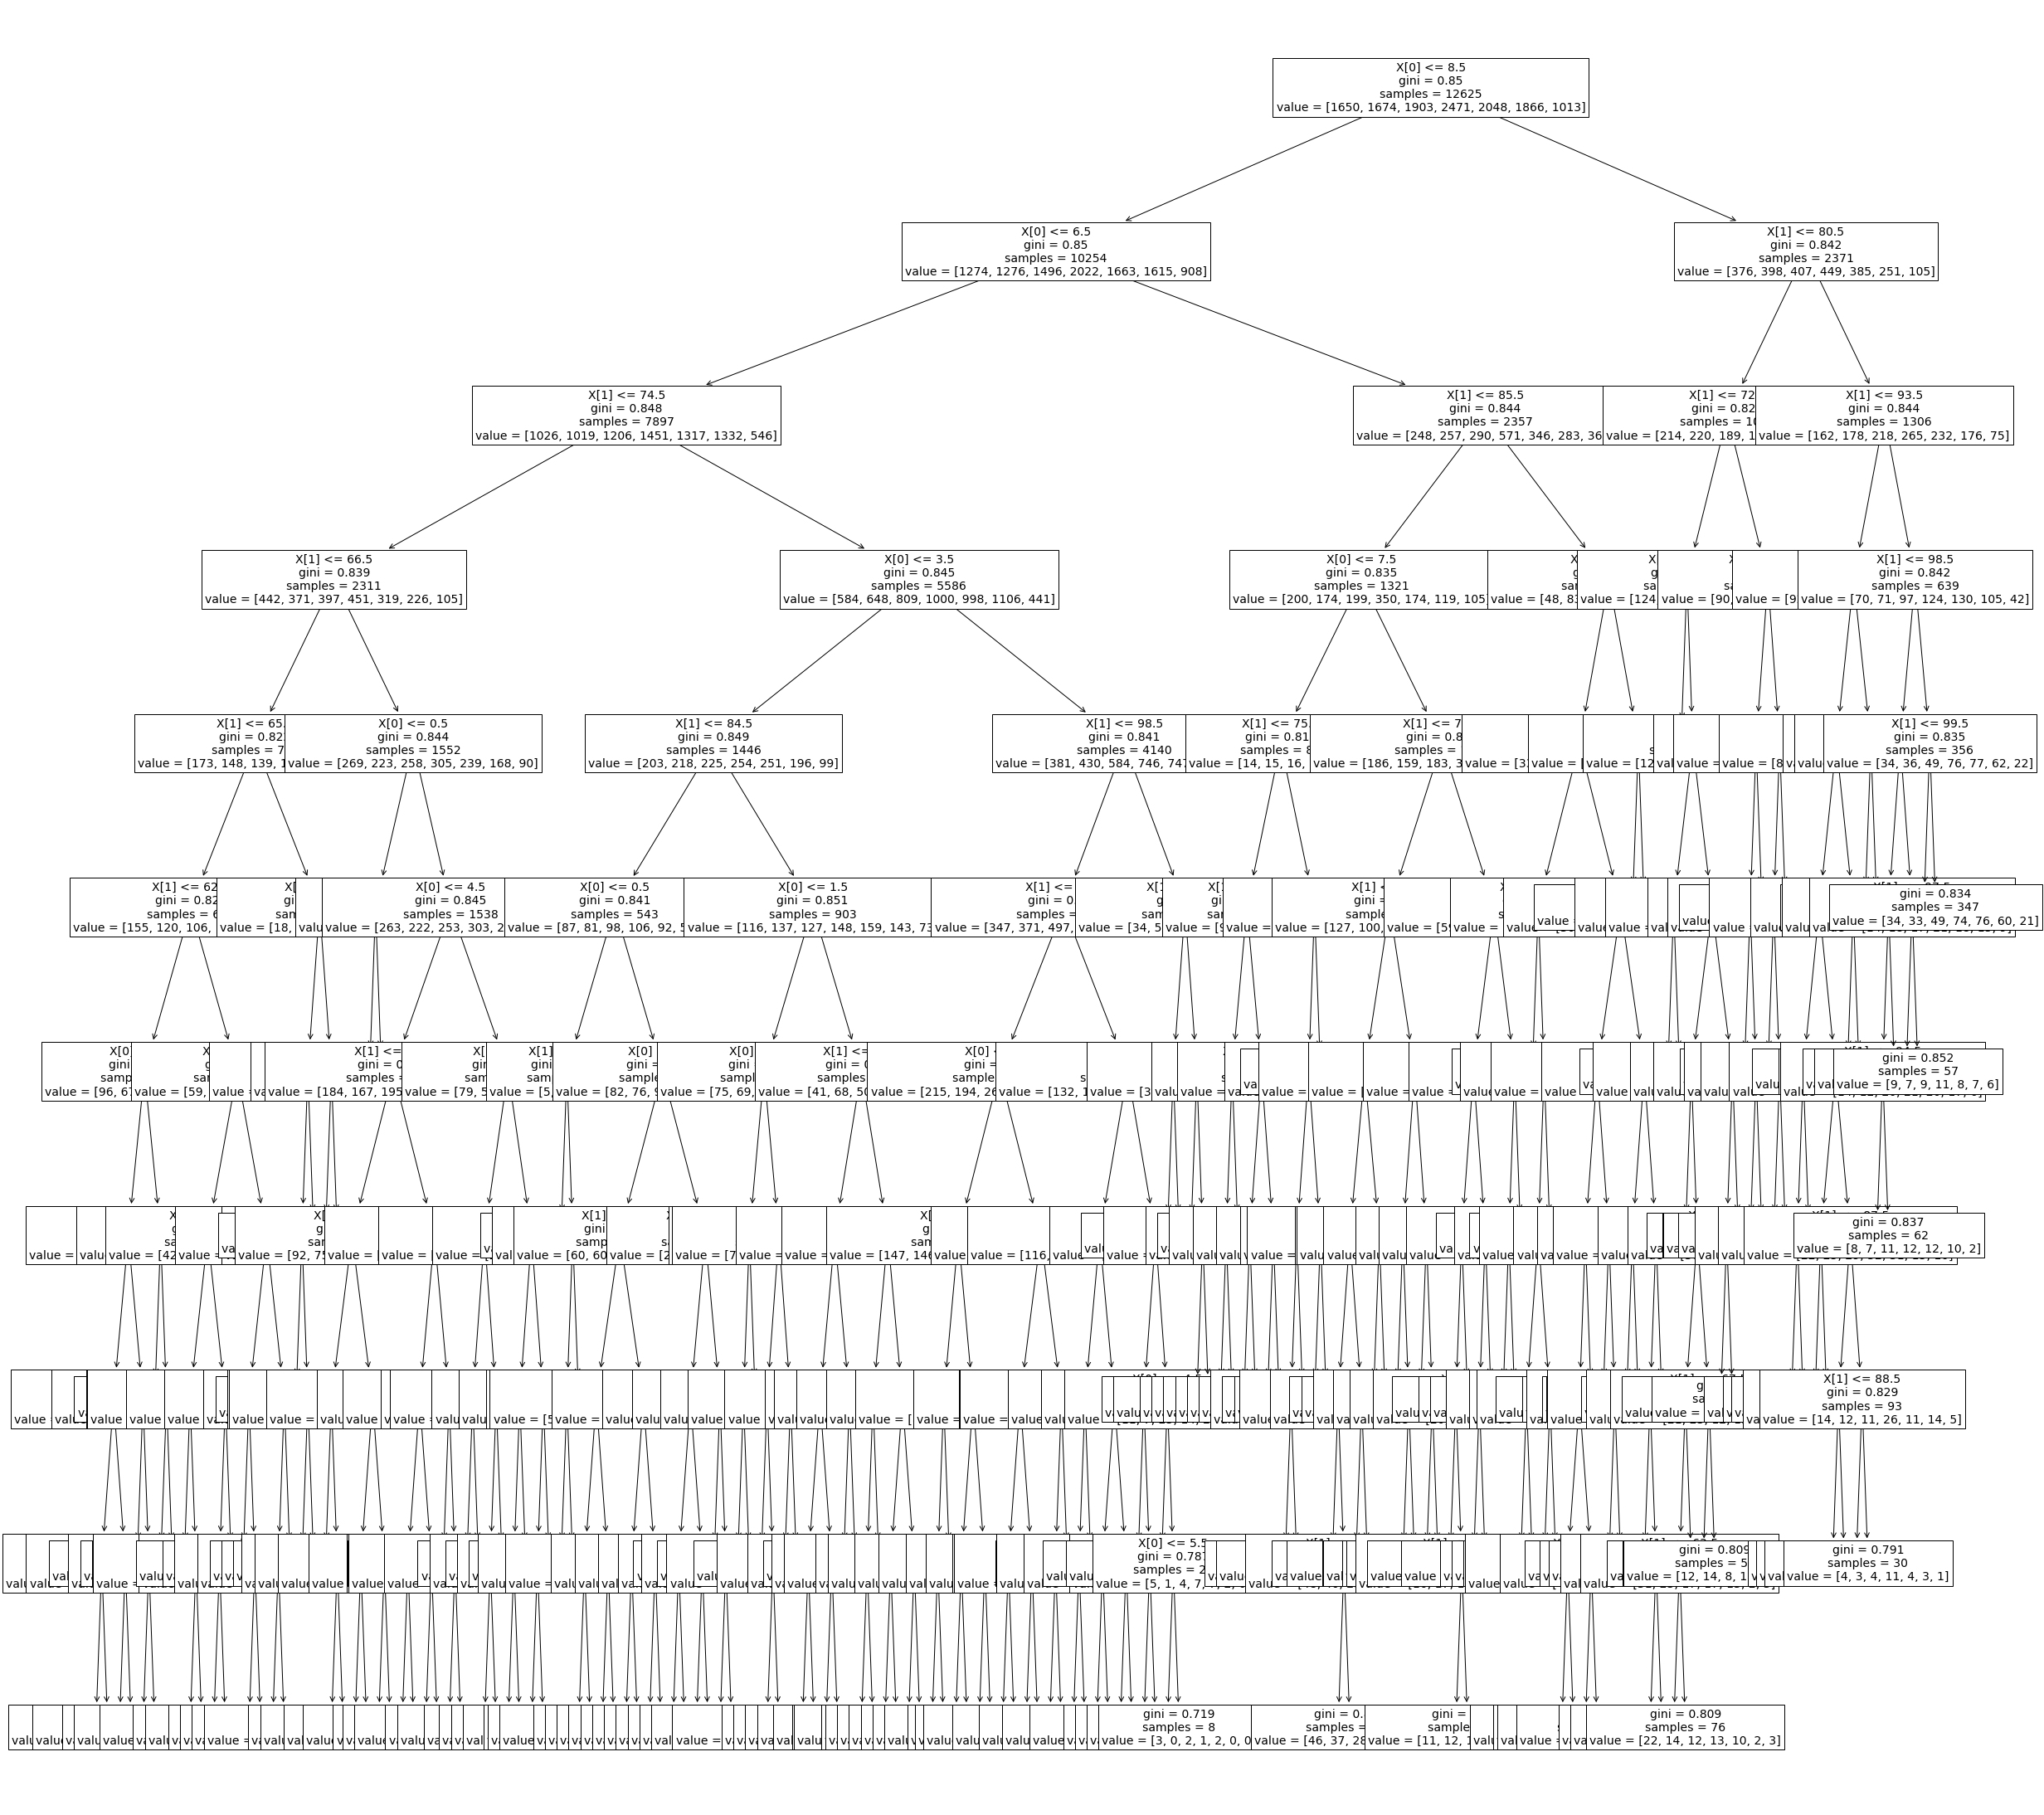

In [ ]:
# plot tree
plt.figure(figsize=(40,40))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=14)

plt.savefig('decision_tree.png', dpi=200)
plt.show()

### Correllazione 

In [ ]:
print(y_test.shape)
print(y_pred.shape)
data = pd.crosstab(y_test, y_pred)

#Chi-squared test statistic, sample size, and minimum of rows and columns
X2 = stats.chi2_contingency(data, correction=False)[0]
n = np.sum(data)
minDim = min(data.shape)-1

#calculate Cramer's V 
V = np.sqrt((X2/n) / minDim)

#display Cramer's V
print('Correlazione tra classi predette e classi effettive {} '.format(V))


(257,)
(257,)
Correlazione tra classi predette e classi effettive col_0
0.0     0.679626
10.0    0.667379
20.0    0.856500
30.0    0.376453
40.0    0.515113
50.0    0.565483
60.0    1.064769
dtype: float64 


# TEMPO ANALISI

In [ ]:
stop = datetime.now()
duration = stop - start
print(duration)  

0:05:50.419826
